# Entrenamiento y comparativa de diferentes modelos de Redes Neuronales Convolucionales (CNN)

En este cuaderno vamos a proceder con el entrenamiento de diferentes arquitecturas de red neuronal convolucional con las imágenes que preprocesamos en el cuaderno ``image_loading.ipynb``. Para ello, haremos uso de la librería ``Keras`` para implementar tres arquitecturas diferentes. En concreto entrenaremos y compararemos las arquitecturas Le-Net 5, VGG-16 y Lu-Net en cuatro experimentos con diferentes características. 

La explicación de cada una de las arquitecturas se reserva a la memoria correspondiente a este trabajo. Sin embargo, a continuación en cada subapartado de este cuaderno realizaremos una breve explicación de cada uno de los experimentos llevados a cabo.

In [1]:
!pip install --upgrade tensorflow
!pip install keras-cv

import cv2
import joblib
import pandas as pd 
import numpy as np
import albumentations as A
import tensorflow as tf
from time import time
from random import seed
from tensorflow import keras 
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Conv2DTranspose, Dropout
from keras_cv.layers import DropBlock2D
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.metrics import Precision, BinaryAccuracy, Recall
from tensorflow.keras.regularizers import L2
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore') 
tf.config.run_functions_eagerly(True)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
You do not have Waymo Open Dataset installed, so KerasCV Waymo metrics are not available.


In [2]:
DATA_PATH = './data'
def load_dataset():
    X_yes = np.load(f'{DATA_PATH}/def_yes_images.npy')
    X_no = np.load(f'{DATA_PATH}/def_no_images.npy')
    classes = np.load(f'{DATA_PATH}/classes.npy')

    print(f'X_yes shape: {X_yes.shape}')
    print(f'X_no shape {X_no.shape}')
    print(f'classes shape: {classes.shape}')

    return X_yes, X_no, classes

def reshape_dataset(X_yes, X_no):
    X = np.row_stack((X_yes, X_no))
    N, SIZE_H, SIZE_V = X.shape
    X = np.reshape(X, newshape=(N, SIZE_H * SIZE_V))
    print(f'X shape: {X.shape}')
    return X

def data_augmentation(imgs, classes, aug_per_image, imgs_trans):
    new_images, new_classes = [], []
    for img, y, i in zip(imgs, classes, range(1, len(imgs) + 1)):
        for _ in range(aug_per_image):
            tmp_img = imgs_trans(image=img)["image"]
            new_images.append(tmp_img)
            new_classes.append(y)
        if i % 50 == 0: print(f'[!] {i} images agumented...')
    print(f'[!] Total of {len(imgs)} images augmented!\n')
    return new_images, new_classes

def data_augmentation_with_class(imgs, classes, augs_yes, augs_no, imgs_trans): 
    new_images, new_classes = [], []
    for img, y, i in zip(imgs, classes, range(1, len(imgs) + 1)):
        if y == 1:
            iters = augs_yes 
        else:
            iters = augs_no 
        for _ in range(iters):
          tmp_img = imgs_trans(image=img)["image"]
          new_images.append(tmp_img)
          new_classes.append(y)
        if i % 50 == 0: print(f'[!] {i} images agumented...')
    print(f'[!] Total of {len(imgs)} images augmented!\n')
    return new_images, new_classes

def balanced_accuracy(y_true, y_pred):
    # print(np.unique(y_true.numpy()))
    # print(np.unique(np.round(y_pred.numpy())))
    return balanced_accuracy_score(y_true.numpy(), np.round(y_pred.numpy()))

def fit_evaluate(model, X_train, X_test, X_val, y_val, y_train, y_test, batch_size=32, epochs=100):
    res_model = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val))
    scores_model = model.evaluate(X_test, y_test)
    return res_model, scores_model

def graph_history(df, metrics, epochs=100):
    if len(metrics) == 1:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
        ax.plot(range(1, epochs+1), df[metrics[0]], 'b-', label='Train')
        ax.plot(range(1, epochs+1), df[f'val_{metrics[0]}'], 'r-', label='Validation')
        ax.set_title(metrics[0])
        ax.legend()
        plt.show()
    else:
        fig, ax = plt.subplots(nrows=1, ncols=len(metrics), sharex=True, figsize=(30, 10))
        for i, metric in zip(range(len(metrics)), metrics):
            ax[i].plot(range(1, epochs+1), df[metric], 'b-', label='Train')
            ax[i].plot(range(1, epochs+1), df[f'val_{metric}'], 'r-', label='Validation')
            ax[i].set_title(metric)
            ax[i].legend()
        plt.show()

## Experimento 1: aproximación *naive*

En este primer experimento proponemos una aproximación *naive* al entrenamiento de las redes neuronales. Como sabemos, una de las problemáticas más frecuentes durante el entrenamiento y evaluación de una red neuronal es su clara tendencia al *overfitting*. En el contexto del *machine learning* y el *deep learning*, el *overfitting* se entiende como la tendencia de un modelo a memorizar las muestras del conjunto de entrenamiento y sus características (incluido el ruido de dichas muestras), ofreciendo sin embargo un muy rendimiento pobre en conjuntos de *test* o en muestras no vistas previamente. Esta problemática es incluso más pronunciada cuando la red neuronal presenta una arquitectura compleja con un alto número de parámetros. 

Este tipo de problemas puede solucionarse mediante diferentes técnicas como la *regularización*, la recolección de un mayor número de muestras para crear un *dataset* más grande, o incluso la generación de muestras de forma artificial. Sin embargo, a continuación mostramos el procedimiento de entrenamiento y evaluación de las diferentes arquitecturas con el *dataset* original para comprobar si efectivamente estas arquitecturas presentan *overfitting* debido a su complejidad y número de parámetros. Únicamente utilizaremos un ``StandardScaler`` con el objetivo de mejorar la estabilidad del modelo durante el proceso de entrenamiento.

Otro aspecto importante será la partición del conjunto de datos en conjuntos de entrenamiento, validación y prueba. En este caso hemos optado por un *split* con el 70% de las muestras para el conjunto de entrenamiento, y el 30% restante para el conjunto de test. Del 70% de las muestras de entrenamiento, un 20% se reservará para validación. Además, al estar tratando con un *dataset* ligeramente desbalanceado (61% de las muestras corresponden a imágenes con tejido canceroso, el resto a imágenes que no presentan ese tipo de tejido), realizaremos un *split* con estratificación. Mediante este tipo de *split* garantizamos que en todos los conjuntos se mantiene la proporción de muestras de cada clase.

In [ ]:
X_yes, X_no, classes = load_dataset()
X = np.row_stack((X_yes, X_no))
N, SIZE_H, SIZE_V = X.shape
N_CLASSES = len(np.unique(classes))
ss = StandardScaler()
X_tmp = np.reshape(X, newshape=(N, -1,))
X_tmp = ss.fit_transform(X_tmp)
X = np.reshape(X_tmp, newshape=(N, SIZE_H, SIZE_V))
print(f'X shape {X.shape}')
print(f'Num classes: {N_CLASSES}')

X_yes shape: (134, 224, 224)
X_no shape (86, 224, 224)
classes shape: (220,)
X shape (220, 224, 224)
Num classes: 2


In [ ]:
sd = seed(time())
X_train, X_test, y_train, y_test = train_test_split(X, classes, test_size=0.3, random_state=sd, shuffle=True, stratify=classes)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=sd, shuffle=True, stratify=y_train)

print(f'X_train shape: {X_train.shape}')
print(f'y_train shape {y_train.shape}')
print(f'X_val shape: {X_val.shape}')
print(f'y_val shape {y_val.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (123, 224, 224)
y_train shape (123,)
X_val shape: (31, 224, 224)
y_val shape (31,)
X_test shape: (66, 224, 224)
y_test shape: (66,)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 112, 112, 32)      832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 109, 109, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      51264     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 186624)            0         
                                                                 
 dense (Dense)               (None, 120)               2

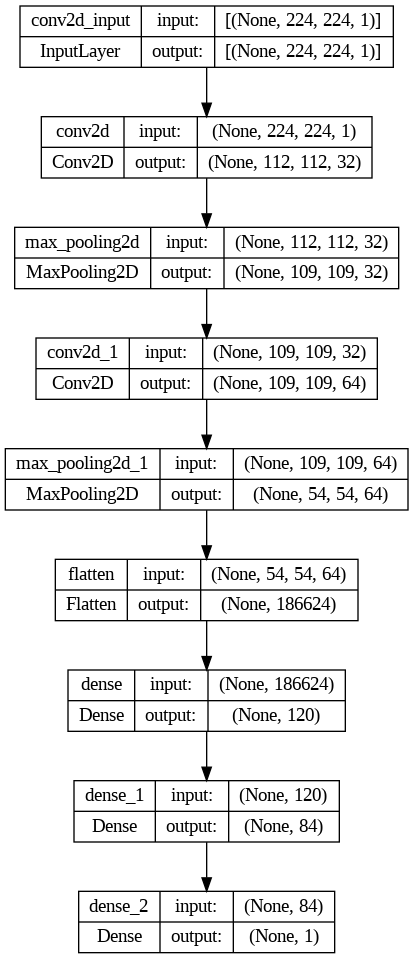

In [ ]:
le_net_5 = keras.Sequential([
    # LAYER 1
    Conv2D(filters=32, kernel_size=(5, 5), strides=2, padding="same", input_shape=(SIZE_H, SIZE_V, 1), activation='relu'),
    MaxPooling2D(pool_size=(4, 4), strides=1, padding="valid"),
    # LAYER 2
    Conv2D(filters=64, kernel_size=(5, 5), strides=1, padding="same", activation='relu'),
    MaxPooling2D(pool_size=(3, 3), strides=2, padding="valid"),
    # FLATTEN
    Flatten(),
    # DENSE LAYERS
    Dense(units=120, activation='relu'),
    Dense(units=84, activation='relu'),
    # OUTPUT
    Dense(units=1, activation='sigmoid')
])

IMG_PATH = './images'
print(le_net_5.summary())
plot_model(le_net_5, to_file=f'{IMG_PATH}/le_net_5.png', show_shapes=True, show_layer_names=True)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 224, 224, 64)      640       
                                                                 
 conv2d_3 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 112, 112, 64)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_5 (Conv2D)           (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                                                  

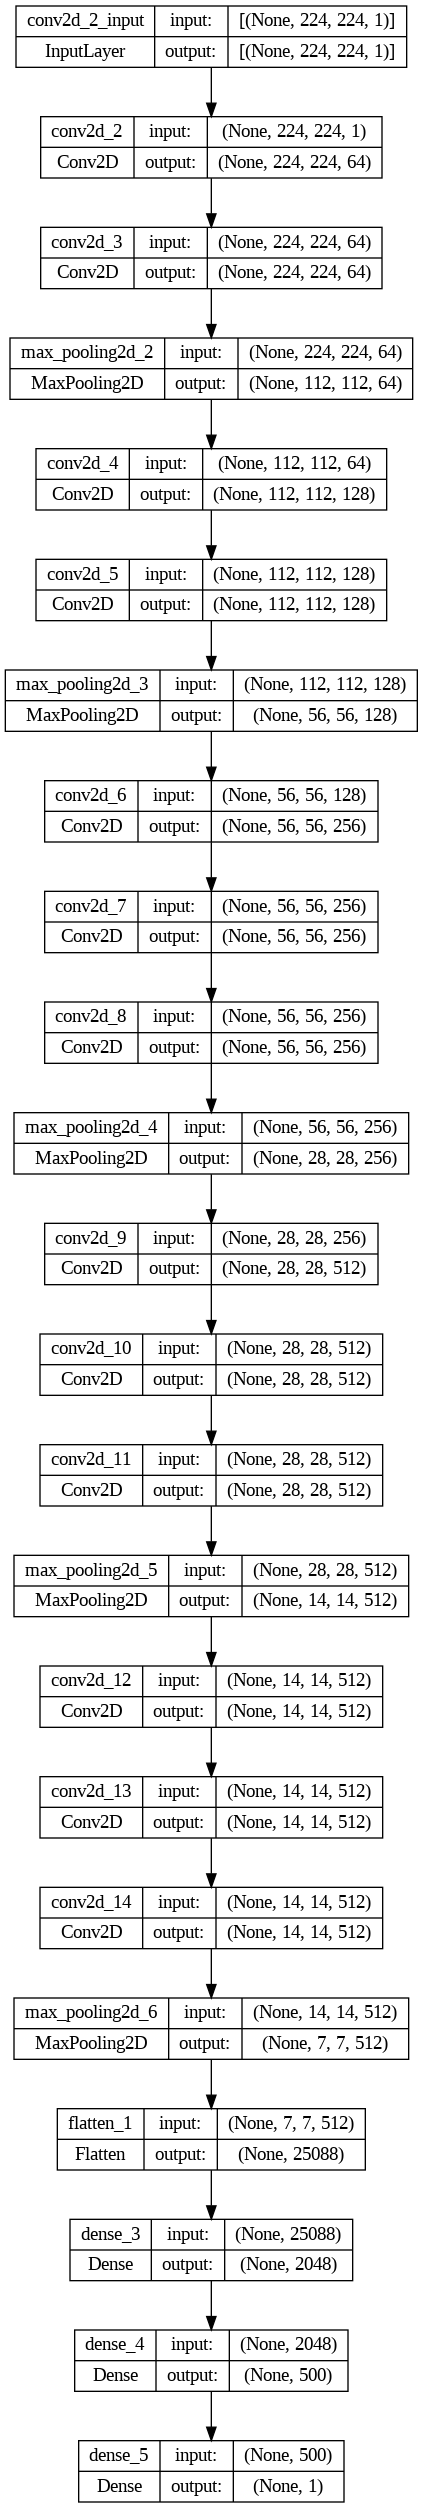

In [ ]:
vgg_16 = keras.Sequential([
    # LAYER 1
    Conv2D(filters=64, kernel_size=(3, 3), strides=1, padding='same', input_shape=(SIZE_H, SIZE_V, 1), activation='relu'),
    Conv2D(filters=64, kernel_size=(3, 3), strides=1, padding='same', activation='relu'),
    # LAYER 2
    MaxPooling2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=128, kernel_size=(3, 3), strides=1, padding='same', activation='relu'),
    Conv2D(filters=128, kernel_size=(3, 3), strides=1, padding='same', activation='relu'),
    # LAYER 3
    MaxPooling2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=256, kernel_size=(3, 3), strides=1, padding='same', activation='relu'),
    Conv2D(filters=256, kernel_size=(3, 3), strides=1, padding='same', activation='relu'),
    Conv2D(filters=256, kernel_size=(3, 3), strides=1, padding='same', activation='relu'),
    # LAYER 4
    MaxPooling2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=512, kernel_size=(3, 3), strides=1, padding='same', activation='relu'),
    Conv2D(filters=512, kernel_size=(3, 3), strides=1, padding='same', activation='relu'),
    Conv2D(filters=512, kernel_size=(3, 3), strides=1, padding='same', activation='relu'),
    # LAYER 5
    MaxPooling2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=512, kernel_size=(3, 3), strides=1, padding='same', activation='relu'),
    Conv2D(filters=512, kernel_size=(3, 3), strides=1, padding='same', activation='relu'),
    Conv2D(filters=512, kernel_size=(3, 3), strides=1, padding='same', activation='relu'),
    # MAXPOOL BEFORE FC
    MaxPooling2D(pool_size=(2, 2), strides=2),
    # FULLY CONNECTED LAYERS
    Flatten(),
    Dense(units=2048, activation='relu'),
    Dense(units=500, activation='relu'),
    # OUTPUT LAYER
    Dense(units=1, activation='sigmoid')
])

print(vgg_16.summary())
plot_model(vgg_16, to_file=f'{IMG_PATH}/vgg_16.png', show_shapes=True, show_layer_names=True)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 224, 224, 32)      320       
                                                                 
 conv2d_16 (Conv2D)          (None, 224, 224, 32)      9248      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 112, 112, 32)     0         
 2D)                                                             
                                                                 
 conv2d_17 (Conv2D)          (None, 112, 112, 64)      18496     
                                                                 
 conv2d_18 (Conv2D)          (None, 112, 112, 64)      36928     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                  

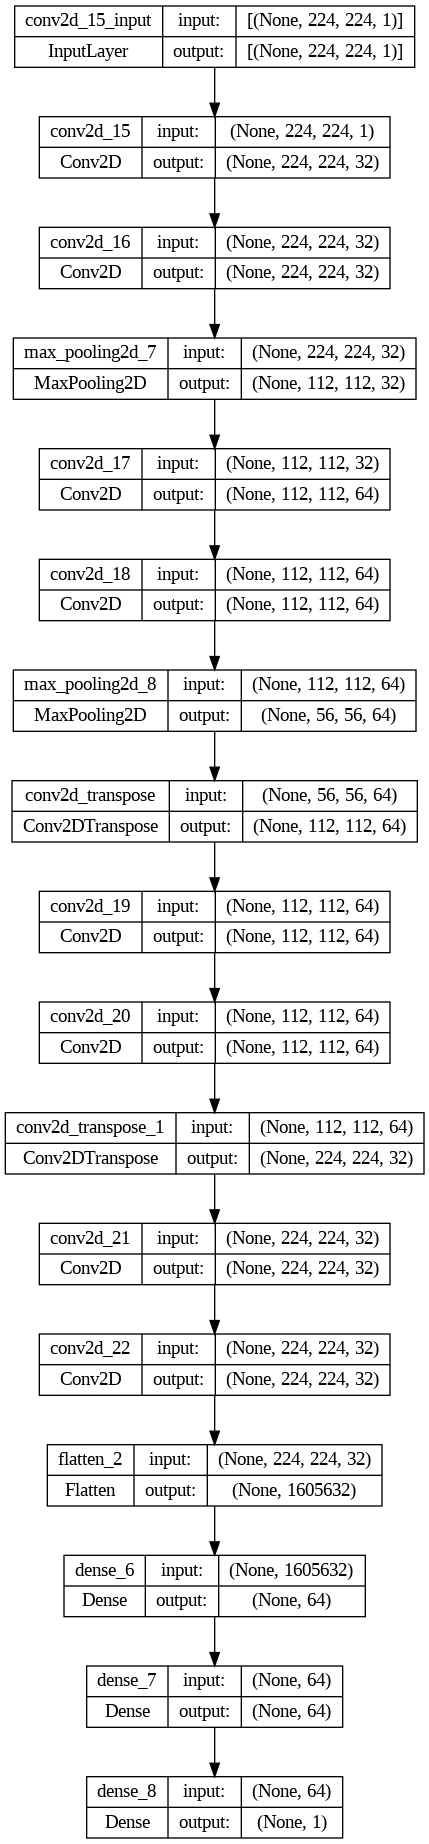

In [ ]:
lu_net = keras.Sequential([
    # LAYER 1
    Conv2D(filters=32, kernel_size=(3, 3), strides=1, padding='same', input_shape=(SIZE_H, SIZE_V, 1), activation='elu'),
    Conv2D(filters=32, kernel_size=(3, 3), strides=1, padding='same', activation='elu'),
    MaxPooling2D(pool_size=(2, 2), strides=2),
    # LAYER 2
    Conv2D(filters=64, kernel_size=(3, 3), strides=1, padding='same', activation='elu'),
    Conv2D(filters=64, kernel_size=(3, 3), strides=1, padding='same', activation='elu'),
    MaxPooling2D(pool_size=(2, 2), strides=2),
    # LAYER 3
    Conv2DTranspose(filters=64, kernel_size=(2, 2), strides=2, padding='same', activation='elu'),
    Conv2D(filters=64, kernel_size=(3, 3), strides=1, padding='same', activation='elu'),
    Conv2D(filters=64, kernel_size=(3, 3), strides=1, padding='same', activation='elu'),
    # LAYER 4
    Conv2DTranspose(filters=32, kernel_size=(2, 2), strides=2, padding='same', activation='elu'),
    Conv2D(filters=32, kernel_size=(3, 3), strides=1, padding='same', activation='elu'),
    Conv2D(filters=32, kernel_size=(3, 3), strides=1, padding='same', activation='elu'),
    # Fully connected layers
    Flatten(),
    Dense(units=64, activation='sigmoid'),
    Dense(units=64, activation='sigmoid'),
    # OUTPUT
    Dense(units=1, activation='sigmoid')
])

print(lu_net.summary())
plot_model(lu_net, to_file=f'{IMG_PATH}/lu_net.png', show_shapes=True, show_layer_names=True)

Tanto para este experimento como para todos los restantes, haremos uso de un optimizador ``Adam`` con una tasa de aprendizaje de ``1e-5``. En cuanto a las métricas, calcularemos la precisión, exactitud, exhaustividad y exactitud balanceda. En este caso, la exactitud balanceada ofrece una medida más representativa del rendimiento de las redes, pues como hemos visto previamente, el *dataset* se encuentra ligeramente desbalanceado. Finalmente, usaremos la ``binary_crossentropy`` como función de pérdida pues nos encontramos frente a un problema de clasificación binaria. 

In [ ]:
opt = keras.optimizers.legacy.Adam(learning_rate=1e-5)
METRICS = [
    Precision(),
    BinaryAccuracy(),
    Recall(),
    balanced_accuracy
]

le_net_5.compile(optimizer=opt, loss='binary_crossentropy', metrics=METRICS)
vgg_16.compile(optimizer=opt, loss='binary_crossentropy', metrics=METRICS)
lu_net.compile(optimizer=opt, loss='binary_crossentropy', metrics=METRICS)

In [ ]:
res_le_net, scores_le_net = fit_evaluate(le_net_5, X_train, X_test, X_val, y_val, y_train, y_test)

Epoch 1/100
4/4 [==============================] - 6s 188ms/step - loss: 0.6463 - precision: 0.6147 - binary_accuracy: 0.5935 - recall: 0.8933 - balanced_accuracy: 0.4980 - val_loss: 0.7608 - val_precision: 0.6129 - val_binary_accuracy: 0.6129 - val_recall: 1.0000 - val_balanced_accuracy: 0.5000
Epoch 2/100
4/4 [==============================] - 0s 102ms/step - loss: 0.5751 - precision: 0.6762 - binary_accuracy: 0.6911 - recall: 0.9467 - balanced_accuracy: 0.6291 - val_loss: 0.7249 - val_precision: 0.5909 - val_binary_accuracy: 0.5161 - val_recall: 0.6842 - val_balanced_accuracy: 0.4671
Epoch 3/100
4/4 [==============================] - 0s 114ms/step - loss: 0.5291 - precision: 0.8636 - binary_accuracy: 0.7805 - recall: 0.7600 - balanced_accuracy: 0.7978 - val_loss: 0.7873 - val_precision: 0.6429 - val_binary_accuracy: 0.6452 - val_recall: 0.9474 - val_balanced_accuracy: 0.5570
Epoch 4/100
4/4 [==============================] - 0s 106ms/step - loss: 0.5053 - precision: 0.7019 - binary_

In [ ]:
df_le_net_5 = pd.DataFrame(res_le_net.history)
df_le_net_5.head()

,loss,precision,binary_accuracy,recall,balanced_accuracy,val_loss,val_precision,val_binary_accuracy,val_recall,val_balanced_accuracy
0,0.646299,0.614679,0.593496,0.893333,0.498016,0.760777,0.612903,0.612903,1.000000,0.500000
1,0.575131,0.676190,0.691057,0.946667,0.629055,0.724891,0.590909,0.516129,0.684211,0.467105
2,0.529081,0.863636,0.780488,0.760000,0.797803,0.787306,0.642857,0.645161,0.947368,0.557018
3,0.505302,0.701923,0.731707,0.973333,0.643693,0.840932,0.620690,0.612903,0.947368,0.515351
4,0.462946,0.818182,0.788618,0.840000,0.784610,0.761372,0.705882,0.612903,0.631579,0.607456


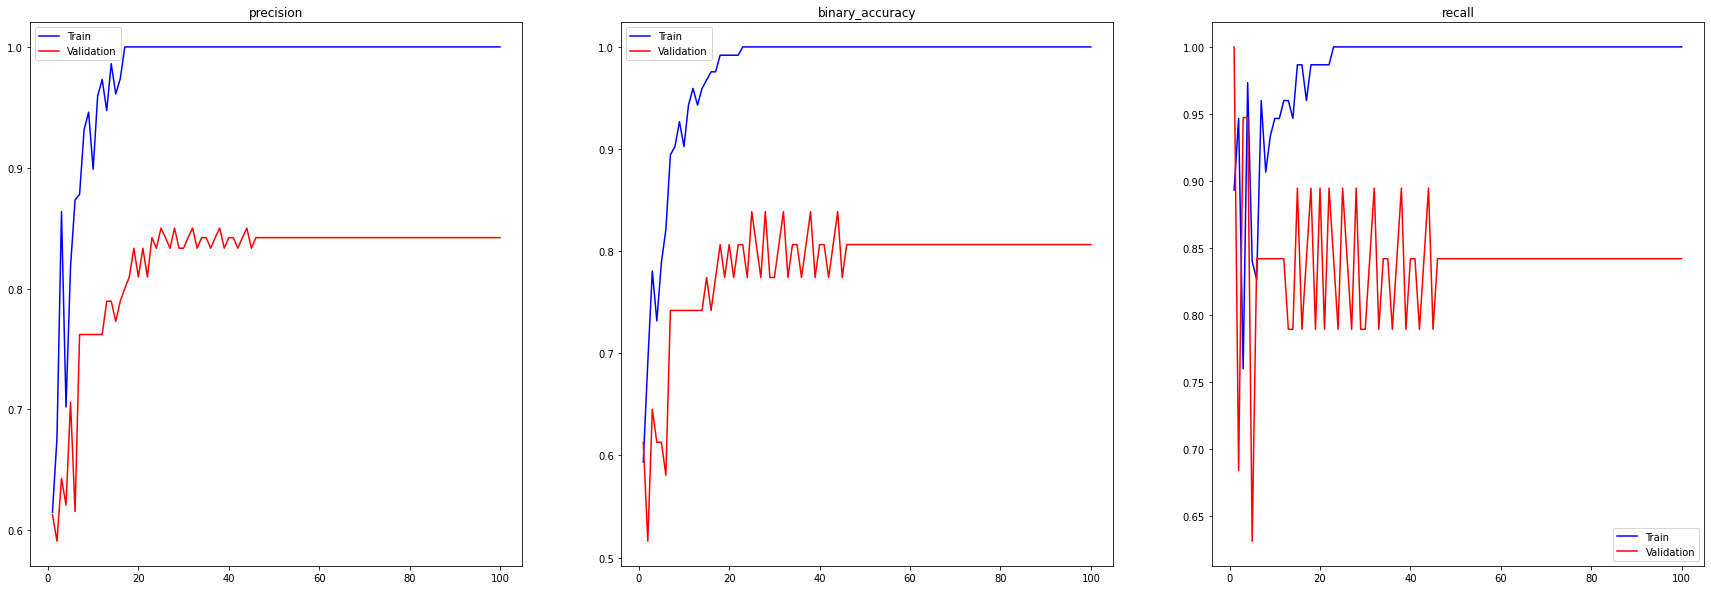

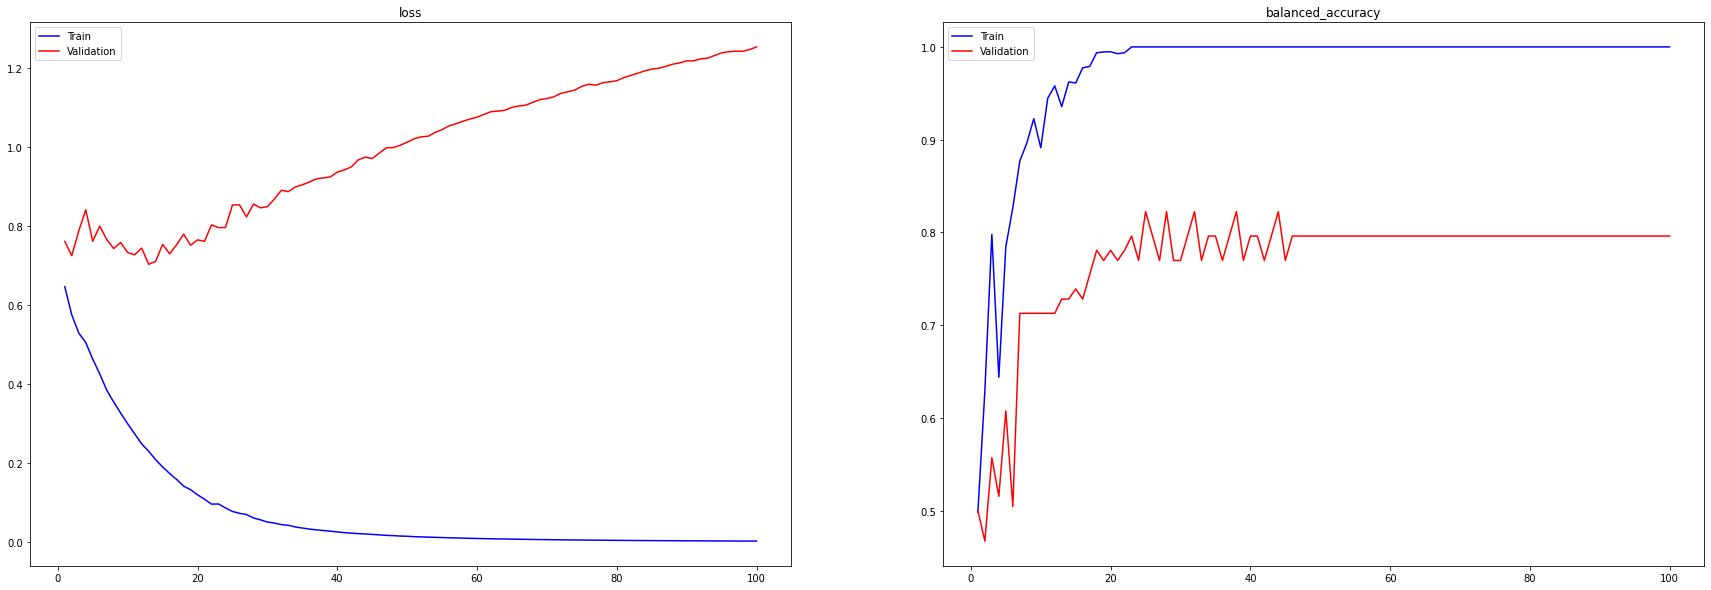

In [ ]:
metrics_1, metrics_2 = ['precision', 'binary_accuracy', 'recall'], ['loss', 'balanced_accuracy']
graph_history(df_le_net_5, metrics_1)
graph_history(df_le_net_5, metrics_2)

In [ ]:
res_vgg_16, scores_vgg_16 = fit_evaluate(vgg_16, X_train, X_test, X_val, y_val, y_train, y_test)

Epoch 1/100
4/4 [==============================] - 4s 765ms/step - loss: 0.6888 - precision: 0.6947 - binary_accuracy: 0.6614 - recall: 0.7913 - balanced_accuracy: 0.5074 - val_loss: 0.6844 - val_precision: 0.6129 - val_binary_accuracy: 0.6129 - val_recall: 1.0000 - val_balanced_accuracy: 0.5000
Epoch 2/100
4/4 [==============================] - 1s 160ms/step - loss: 0.6430 - precision: 0.6098 - binary_accuracy: 0.6098 - recall: 1.0000 - balanced_accuracy: 0.5000 - val_loss: 0.8904 - val_precision: 0.6129 - val_binary_accuracy: 0.6129 - val_recall: 1.0000 - val_balanced_accuracy: 0.5000
Epoch 3/100
4/4 [==============================] - 1s 160ms/step - loss: 0.6421 - precision: 0.6098 - binary_accuracy: 0.6098 - recall: 1.0000 - balanced_accuracy: 0.5000 - val_loss: 0.6949 - val_precision: 0.6129 - val_binary_accuracy: 0.6129 - val_recall: 1.0000 - val_balanced_accuracy: 0.5000
Epoch 4/100
4/4 [==============================] - 1s 159ms/step - loss: 0.6267 - precision: 0.6098 - binary_

In [ ]:
df_vgg_16 = pd.DataFrame(res_vgg_16.history)
df_vgg_16.head()

,loss,precision,binary_accuracy,recall,balanced_accuracy,val_loss,val_precision,val_binary_accuracy,val_recall,val_balanced_accuracy
0,0.688833,0.694656,0.661376,0.791304,0.507353,0.684355,0.612903,0.612903,1.0,0.5
1,0.642995,0.609756,0.609756,1.000000,0.500000,0.890403,0.612903,0.612903,1.0,0.5
2,0.642083,0.609756,0.609756,1.000000,0.500000,0.694853,0.612903,0.612903,1.0,0.5
3,0.626667,0.609756,0.609756,1.000000,0.500000,0.696530,0.612903,0.612903,1.0,0.5
4,0.606497,0.609756,0.609756,1.000000,0.500000,0.800606,0.612903,0.612903,1.0,0.5


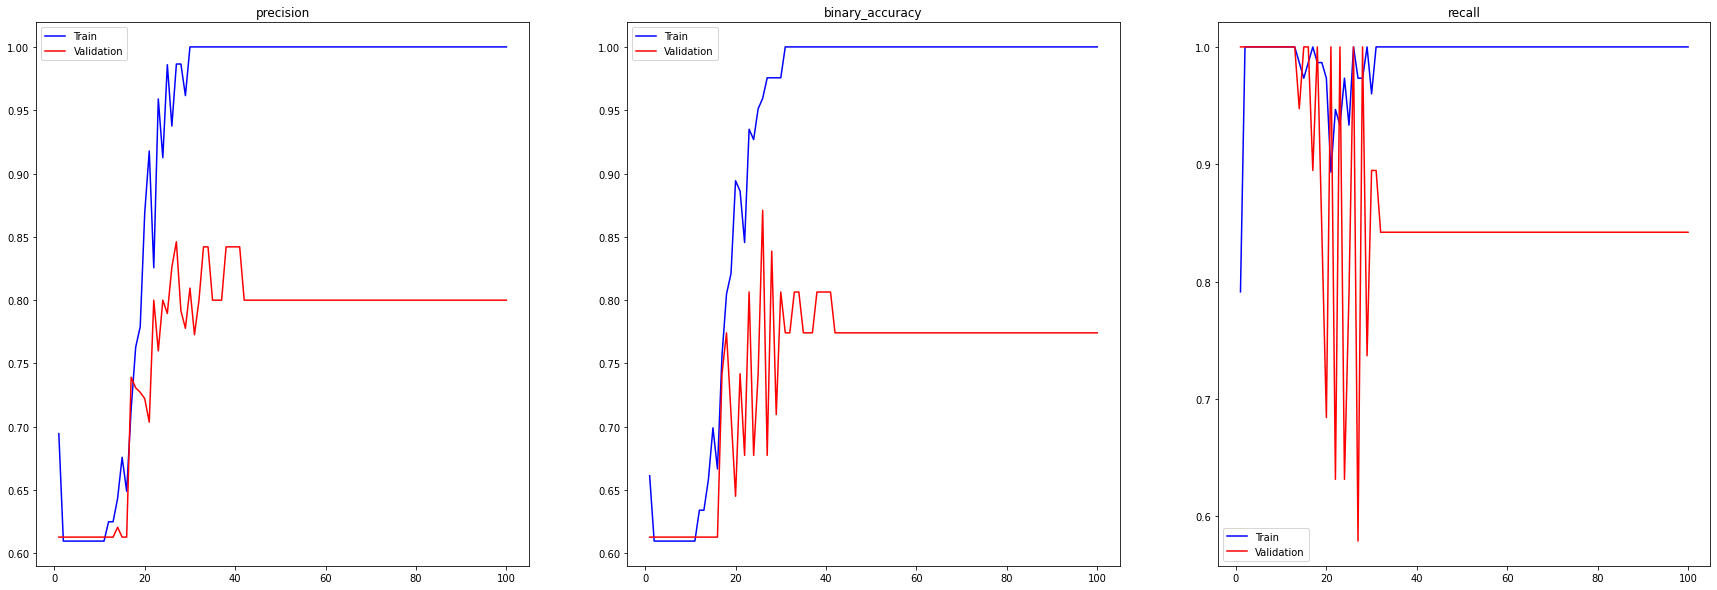

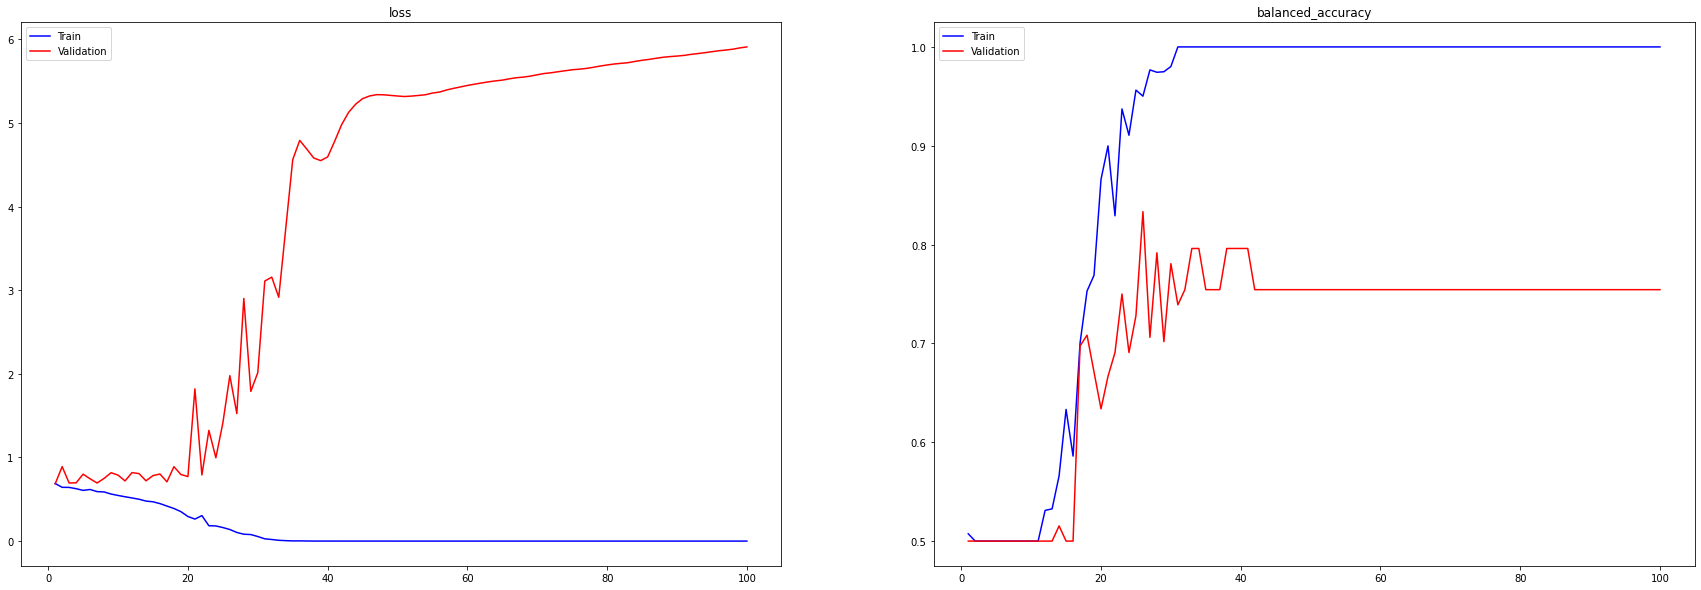

In [ ]:
graph_history(df_vgg_16, metrics_1)
graph_history(df_vgg_16, metrics_2)

In [ ]:
res_lu_net, scores_lu_net = fit_evaluate(lu_net, X_train, X_test, X_val, y_val, y_train, y_test)

Epoch 1/100
4/4 [==============================] - 2s 351ms/step - loss: 0.6543 - precision: 0.6624 - binary_accuracy: 0.6614 - recall: 0.9043 - balanced_accuracy: 0.5000 - val_loss: 0.7005 - val_precision: 0.6333 - val_binary_accuracy: 0.6452 - val_recall: 1.0000 - val_balanced_accuracy: 0.5417
Epoch 2/100
4/4 [==============================] - 1s 157ms/step - loss: 0.5978 - precision: 0.7010 - binary_accuracy: 0.7073 - recall: 0.9067 - balanced_accuracy: 0.6581 - val_loss: 0.6997 - val_precision: 0.6071 - val_binary_accuracy: 0.5806 - val_recall: 0.8947 - val_balanced_accuracy: 0.4890
Epoch 3/100
4/4 [==============================] - 1s 152ms/step - loss: 0.5573 - precision: 0.7711 - binary_accuracy: 0.7561 - recall: 0.8533 - balanced_accuracy: 0.6991 - val_loss: 0.6562 - val_precision: 0.6429 - val_binary_accuracy: 0.6452 - val_recall: 0.9474 - val_balanced_accuracy: 0.5570
Epoch 4/100
4/4 [==============================] - 1s 152ms/step - loss: 0.5118 - precision: 0.8193 - binary_

In [ ]:
df_lu_net = pd.DataFrame(res_lu_net.history)
df_lu_net.head()

,loss,precision,binary_accuracy,recall,balanced_accuracy,val_loss,val_precision,val_binary_accuracy,val_recall,val_balanced_accuracy
0,0.654341,0.662420,0.661376,0.904348,0.500000,0.700513,0.633333,0.645161,1.000000,0.541667
1,0.597784,0.701031,0.707317,0.906667,0.658095,0.699708,0.607143,0.580645,0.894737,0.489035
2,0.557280,0.771084,0.756098,0.853333,0.699100,0.656221,0.642857,0.645161,0.947368,0.557018
3,0.511784,0.819277,0.821138,0.906667,0.800009,0.622564,0.666667,0.677419,0.947368,0.598684
4,0.482186,0.820225,0.853659,0.973333,0.818830,0.610376,0.692308,0.709677,0.947368,0.640351


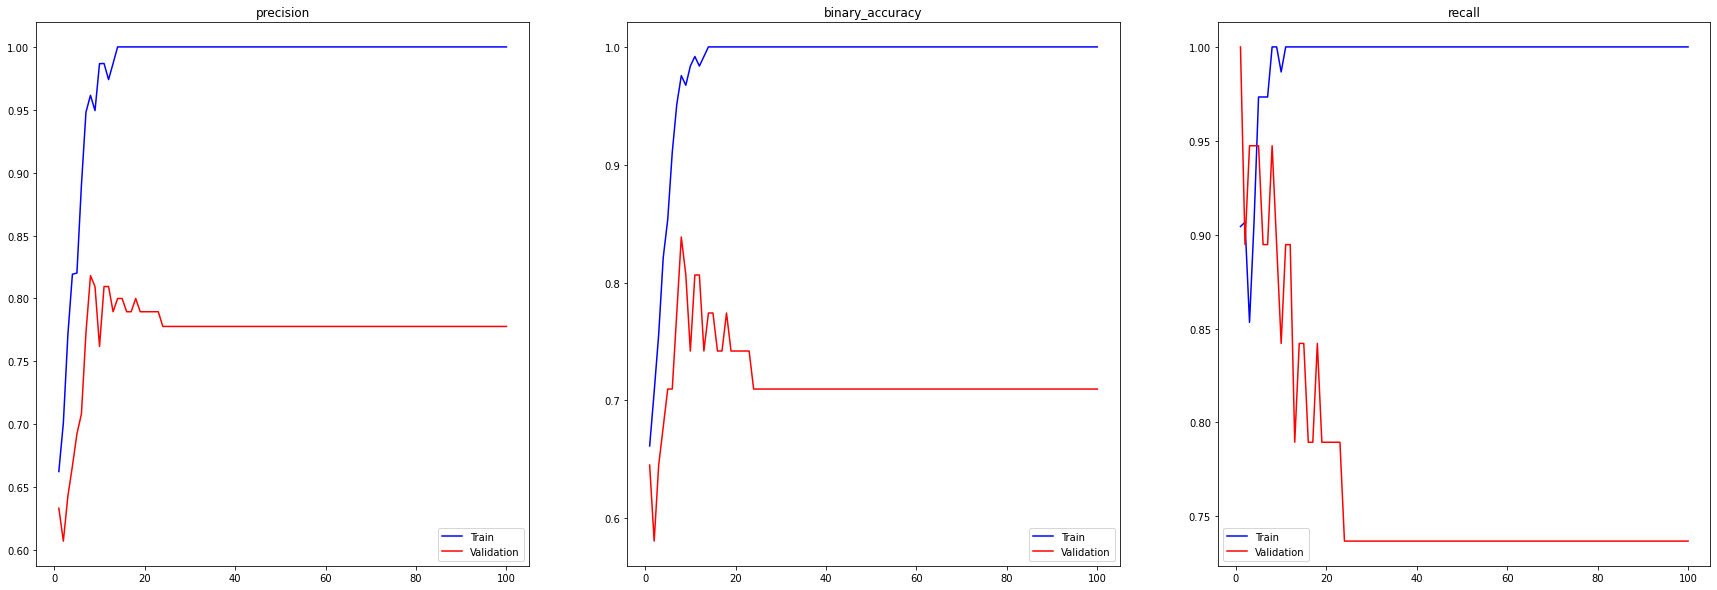

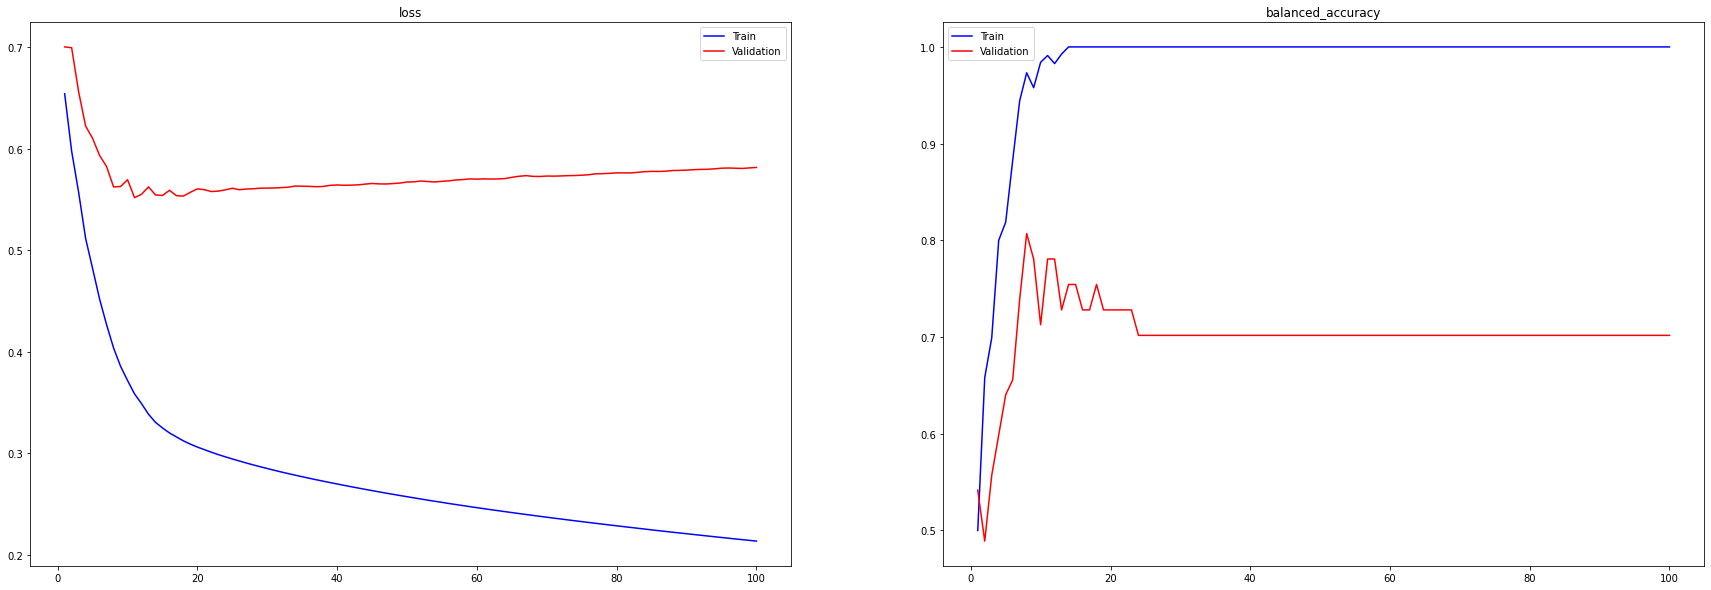

In [ ]:
graph_history(df_lu_net, metrics_1)
graph_history(df_lu_net, metrics_2)

In [ ]:
scores = [scores_le_net, scores_vgg_16, scores_lu_net]
losses, precisions = [score[0] for score in scores], [score[1] for score in scores]
bin_accs, recalls = [score[2] for score in scores], [score[3] for score in scores]
baccs = [score[4] for score in scores]

scores_df = pd.DataFrame({
    'Loss':losses, 
    'Precision':precisions,
    'Binary Accuracy':bin_accs,
    'Recall':recalls,
    'Balanced Accuracy':baccs
}, index=['Le-Net 5', 'VGG-16', 'Lu-Net'])
scores_df.head()

,Loss,Precision,Binary Accuracy,Recall,Balanced Accuracy
Le-Net 5,0.855953,0.820513,0.772727,0.800,0.687951
VGG-16,5.152152,0.852941,0.757576,0.725,0.838745
Lu-Net,0.552269,0.755556,0.742424,0.850,0.649711


In [ ]:
RES_PATH = './results'
scores_df.to_csv(f'{RES_PATH}/test_scores_1.csv')
df_le_net_5.to_csv(f'{RES_PATH}/le_net_5_metrics_1.csv')
df_vgg_16.to_csv(f'{RES_PATH}/vgg_16_metrics_1.csv')
df_lu_net.to_csv(f'{RES_PATH}/lu_net_metrics_1.csv')

De los resultados obtenidos hasta el momento, podemos extraer varias conclusiones:

- **Todas las arquitecturas presentan un claro *overfitting***. Se alcanzan valores perfectos de todas las métricas del conjunto de entrenamiento en unas 30-40 iteraciones mientras que las métricas para el conjunto de *validación* quedan "estancadas" en valores entorno al 0.6-0.7. 

- **La función de pérdida aumenta para el conjunto de validación**. Como puede verse, para las tres arquitecturas la función de pérdida para el conjunto de validación comienza a crecer durante las primeras iteraciones, mientras que decrece para el conjunto de entrenamiento. De nuevo, esto sugiere un claro *overfitting* de nuestras redes, pues memorizan las muestras de entrenamiento, siendo incapaces de generalizar y ofrecer buenas predicciones para muestras no vistas.

- **Rendimiento pobre para el conjunto de *test***. Como puede verse a partir de los valores del ``DataFrame`` ``scores_df`` las métricas del conjunto de test no resultan favorables. Destacan los valores de la *balanced accuracy* que en ningún caso logran superar el 70%.

En conclusión, esta primera aproximación al problema parece no ser la correcta para obtener los resultados que buscamos.

## Experimento 2: generación de información artificial o *data augmentation*

Como se ha explicado en el subapartado anterior, una forma de prevenir el *overfitting* en cualquier modelo puede pasar por la adición de información a nuestro *dataset*. Esta adición puede ir desde la recolección de nuevas muestras, hasta la generación de muestras adicionales de forma aritifical. Nuestra aproximación va a consistir en la generación de nuevas muestras mediante el módulo ``albumentations``. Este módulo permite tomar las imágenes de nuestro *dataset* original y generar otras nuevas a partir de transformaciones como rotaciones, traslaciones o cambios en el brillo y el contraste. Las transformaciones que realizaremos sobre las imágenes son las que enumeramos a continuación:

- Volteado sobre el eje horizontal.
- Volteado sobre el eje vertical.
- Rotación de 20º en sentido horaro o anti horario.
- Traslación hacia la derecha o la izquierda de hasta un 5% de la amplitud de la imágen.
- Cambio en el brillo de la imágen en un factor del 20%.

Todas estas transformaciones se aplican con una probabilidad del 25%. Nuestro objetivo con estas transformaciones es no solo el de generar un *dataset* con un mayor número de muestras, sino también el de conseguir un dataset balanceado. Por tanto, aplicaremos 20 aumentos por cada imágen que no presenta tejido canceroso (obteniendo un total de 1720 muestras) y 13 aumentos por cada imágen que sí lo presenta (obteniendo 1742 muestras). Generando un *dataset* equilibrado con un total de 3462 muestras buscamos obtener un rendimiento más favorable de las diferentes arquitecturas propuestas.

In [3]:
X_yes, X_no, classes = load_dataset()
X = np.row_stack((X_yes, X_no))
N, SIZE_H, SIZE_V = X.shape
N_CLASSES = len(np.unique(classes))
print(f'X shape {X.shape}')
print(f'Num classes: {N_CLASSES}')

X_yes shape: (134, 224, 224)
X_no shape (86, 224, 224)
classes shape: (220,)
X shape (220, 224, 224)
Num classes: 2


In [4]:
imgs_trans = A.Compose([
    A.HorizontalFlip(p=0.25),
    A.VerticalFlip(p=0.25),
    A.RandomBrightnessContrast(brightness_limit=(-0.2, 0.2), p=0.25),
    A.Rotate(limit=[-20, 20], p=0.25, border_mode=cv2.BORDER_CONSTANT),
    A.Affine(translate_percent=(-0.05, 0.05))
])

N_AUG_NO = 20
N_AUG_YES = np.ceil((N_AUG_NO * X_no.shape[0]) / X_yes.shape[0]).astype(int)
X, classes = data_augmentation_with_class(X, classes, N_AUG_YES, N_AUG_NO, imgs_trans)
X, classes = np.array(X), np.array(classes)

#n_yes = X_yes.shape[0]
#X_yes, y_yes = data_augmentation(X_yes, classes[:n_yes], N_AUG_YES, imgs_trans)
#X_yes, y_yes = np.array(X_yes), np.array(y_yes)
#X_no, y_no = data_augmentation(X_no, classes[n_yes:], N_AUG_NO, imgs_trans)
#X_no, y_no = np.array(X_no), np.array(y_no)
#print(f'X_yes shape: {X_yes.shape}')
#print(f'X_no shape: {X_no.shape}')
#X = np.row_stack((X_yes, X_no))
#classes = np.concatenate((y_yes, y_no))

ss = StandardScaler()
X_tmp = np.reshape(X, newshape=(X.shape[0], -1,))
X_tmp = ss.fit_transform(X_tmp)

X = np.reshape(X_tmp, newshape=(X.shape[0], SIZE_H, SIZE_V))
print(f'X shape: {X.shape}')
print(f'classes shape {classes.shape}')

[!] 50 images agumented...
[!] 100 images agumented...
[!] 150 images agumented...
[!] 200 images agumented...
[!] Total of 220 images augmented!

X shape: (3462, 224, 224)
classes shape (3462,)


In [5]:
sd = seed(time())
X_train, X_test, y_train, y_test = train_test_split(X, classes, test_size=0.3, random_state=sd, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=sd, shuffle=True)

print(f'X_train shape: {X_train.shape}')
print(f'y_train shape {y_train.shape}')
print(f'X_val shape: {X_val.shape}')
print(f'y_val shape {y_val.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (1938, 224, 224)
y_train shape (1938,)
X_val shape: (485, 224, 224)
y_val shape (485,)
X_test shape: (1039, 224, 224)
y_test shape: (1039,)


In [ ]:
EPOCHS_2 = 100
res_le_net, scores_le_net = fit_evaluate(le_net_5, X_train, X_test, X_val, y_val, y_train, y_test, epochs=EPOCHS_2)

Epoch 1/100
61/61 [==============================] - 6s 96ms/step - loss: 0.5532 - precision: 0.7629 - binary_accuracy: 0.7534 - recall: 0.7345 - balanced_accuracy: 0.7524 - val_loss: 0.4188 - val_precision: 0.7992 - val_binary_accuracy: 0.8103 - val_recall: 0.8257 - val_balanced_accuracy: 0.8046
Epoch 2/100
61/61 [==============================] - 6s 91ms/step - loss: 0.3546 - precision: 0.8517 - binary_accuracy: 0.8504 - recall: 0.8481 - balanced_accuracy: 0.8509 - val_loss: 0.3670 - val_precision: 0.8340 - val_binary_accuracy: 0.8515 - val_recall: 0.8755 - val_balanced_accuracy: 0.8481
Epoch 3/100
61/61 [==============================] - 6s 93ms/step - loss: 0.3079 - precision: 0.8785 - binary_accuracy: 0.8736 - recall: 0.8667 - balanced_accuracy: 0.8724 - val_loss: 0.3717 - val_precision: 0.7832 - val_binary_accuracy: 0.8371 - val_recall: 0.9295 - val_balanced_accuracy: 0.8331
Epoch 4/100
61/61 [==============================] - 6s 94ms/step - loss: 0.2533 - precision: 0.9235 - bin

In [ ]:
df_le_net_5 = pd.DataFrame(res_le_net.history)
df_le_net_5.head()

,loss,precision,binary_accuracy,recall,balanced_accuracy,val_loss,val_precision,val_binary_accuracy,val_recall,val_balanced_accuracy
0,0.553185,0.762876,0.753354,0.734504,0.752415,0.418846,0.799197,0.810309,0.825726,0.804595
1,0.354582,0.851660,0.850361,0.848140,0.850883,0.366962,0.833992,0.851546,0.875519,0.848095
2,0.307925,0.878534,0.873581,0.866736,0.872410,0.371710,0.783217,0.837113,0.929461,0.833138
3,0.253346,0.923486,0.911765,0.897727,0.912413,0.308879,0.872247,0.851546,0.821577,0.840543
4,0.224613,0.926548,0.920021,0.912190,0.917606,0.295063,0.871795,0.861856,0.846473,0.850922


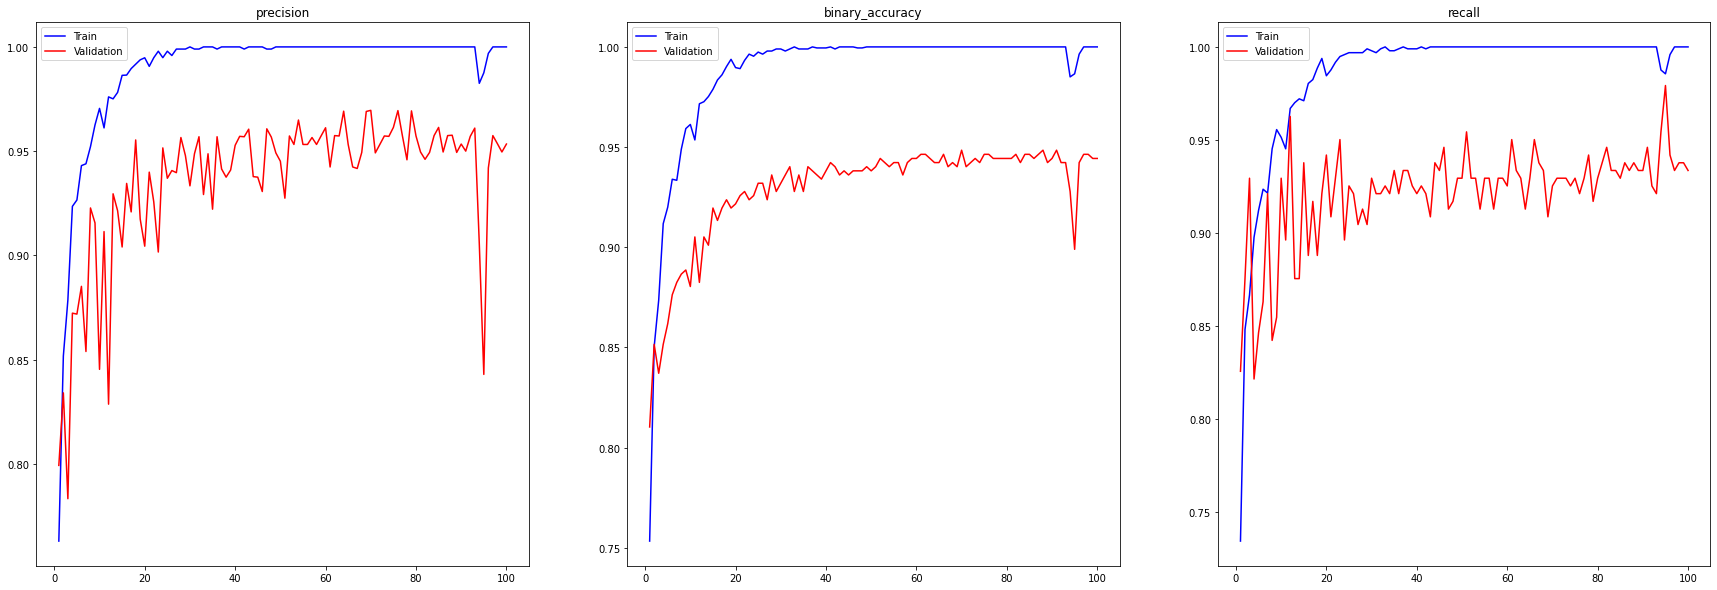

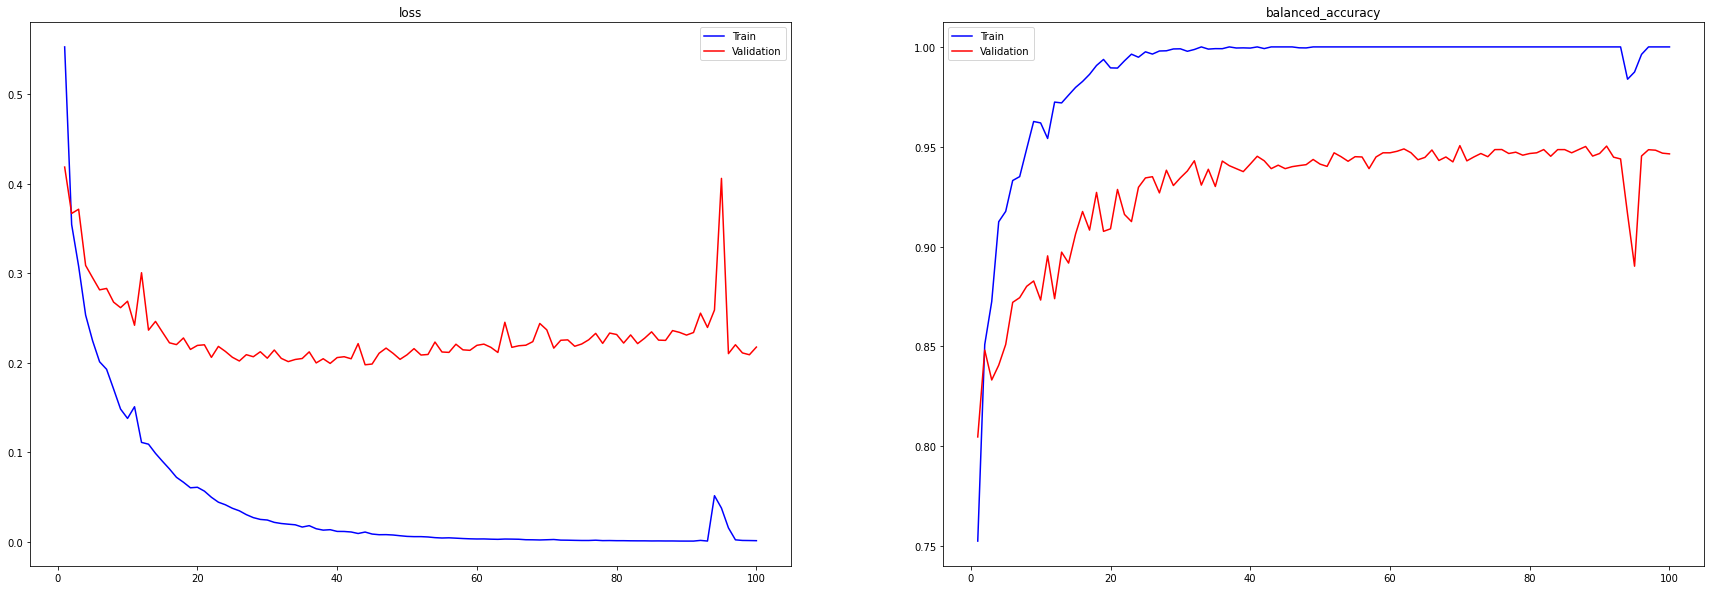

In [ ]:
metrics_1, metrics_2 = ['precision', 'binary_accuracy', 'recall'], ['loss', 'balanced_accuracy']
graph_history(df_le_net_5, metrics_1, epochs=EPOCHS_2)
graph_history(df_le_net_5, metrics_2, epochs=EPOCHS_2)

In [ ]:
RES_PATH = './results'
df_le_net_5.to_csv(f'{RES_PATH}/le_net_5_metrics_2.csv')

In [ ]:
res_vgg_16, scores_vgg_16 = fit_evaluate(vgg_16, X_train, X_test, X_val, y_val, y_train, y_test, epochs=EPOCHS_2)

Epoch 1/100
61/61 [==============================] - 11s 172ms/step - loss: 0.8647 - precision: 0.5607 - binary_accuracy: 0.6001 - recall: 0.9205 - balanced_accuracy: 0.6019 - val_loss: 0.6170 - val_precision: 0.5609 - val_binary_accuracy: 0.6082 - val_recall: 0.9751 - val_balanced_accuracy: 0.6021
Epoch 2/100
61/61 [==============================] - 9s 148ms/step - loss: 0.5119 - precision: 0.7422 - binary_accuracy: 0.7575 - recall: 0.7882 - balanced_accuracy: 0.7618 - val_loss: 0.3963 - val_precision: 0.8995 - val_binary_accuracy: 0.8309 - val_recall: 0.7427 - val_balanced_accuracy: 0.8087
Epoch 3/100
61/61 [==============================] - 9s 149ms/step - loss: 0.3659 - precision: 0.8723 - binary_accuracy: 0.8375 - recall: 0.7903 - balanced_accuracy: 0.8360 - val_loss: 0.3327 - val_precision: 0.8238 - val_binary_accuracy: 0.8515 - val_recall: 0.8921 - val_balanced_accuracy: 0.8398
Epoch 4/100
61/61 [==============================] - 9s 148ms/step - loss: 0.2589 - precision: 0.9188 

In [ ]:
df_vgg_16 = pd.DataFrame(res_vgg_16.history)
df_vgg_16.head()

,loss,precision,binary_accuracy,recall,balanced_accuracy,val_loss,val_precision,val_binary_accuracy,val_recall,val_balanced_accuracy
0,0.864661,0.560730,0.600103,0.920455,0.601856,0.617050,0.560859,0.608247,0.975104,0.602080
1,0.511944,0.742218,0.757482,0.788223,0.761825,0.396281,0.899498,0.830928,0.742739,0.808688
2,0.365895,0.872292,0.837461,0.790289,0.835977,0.332737,0.823755,0.851546,0.892116,0.839792
3,0.258851,0.918771,0.894221,0.864669,0.894441,0.252791,0.906780,0.898969,0.887967,0.879429
4,0.202741,0.944685,0.923633,0.899793,0.924114,0.227582,0.919643,0.890722,0.854772,0.866154


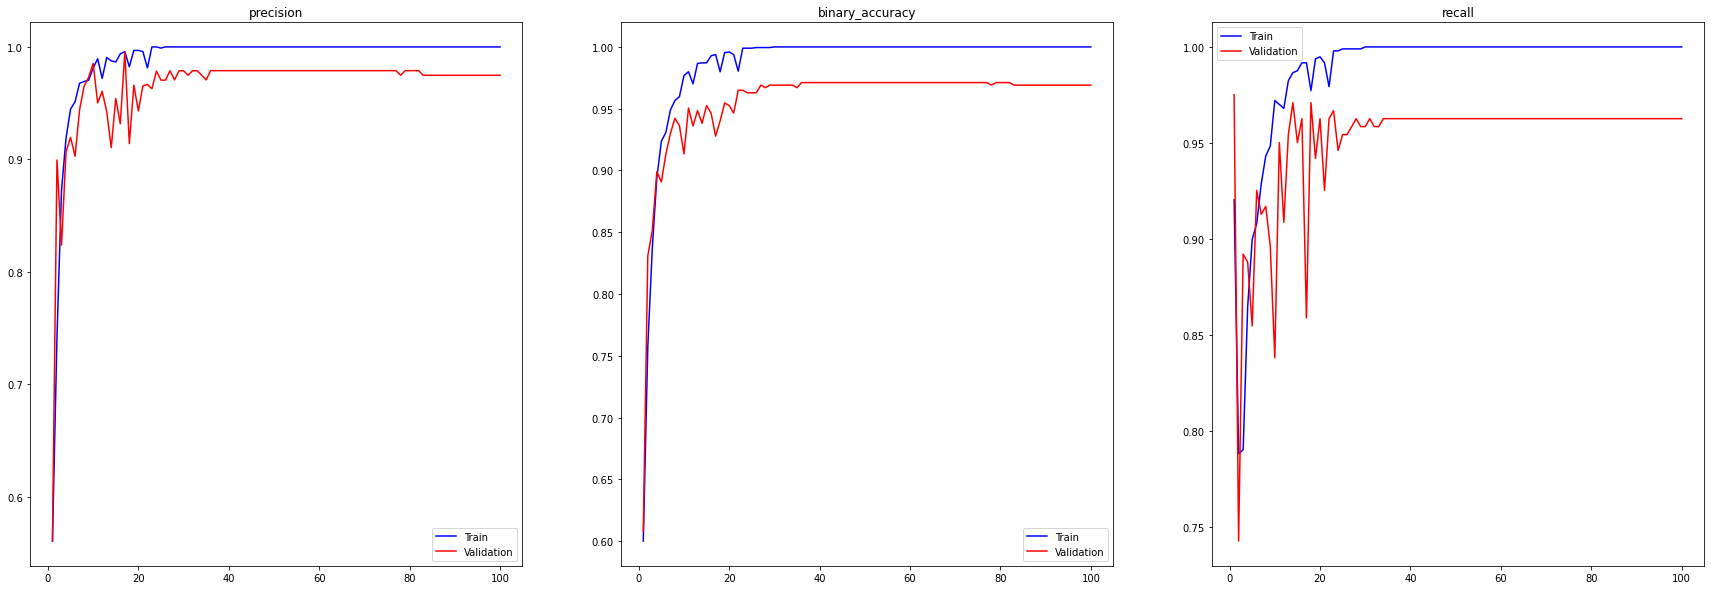

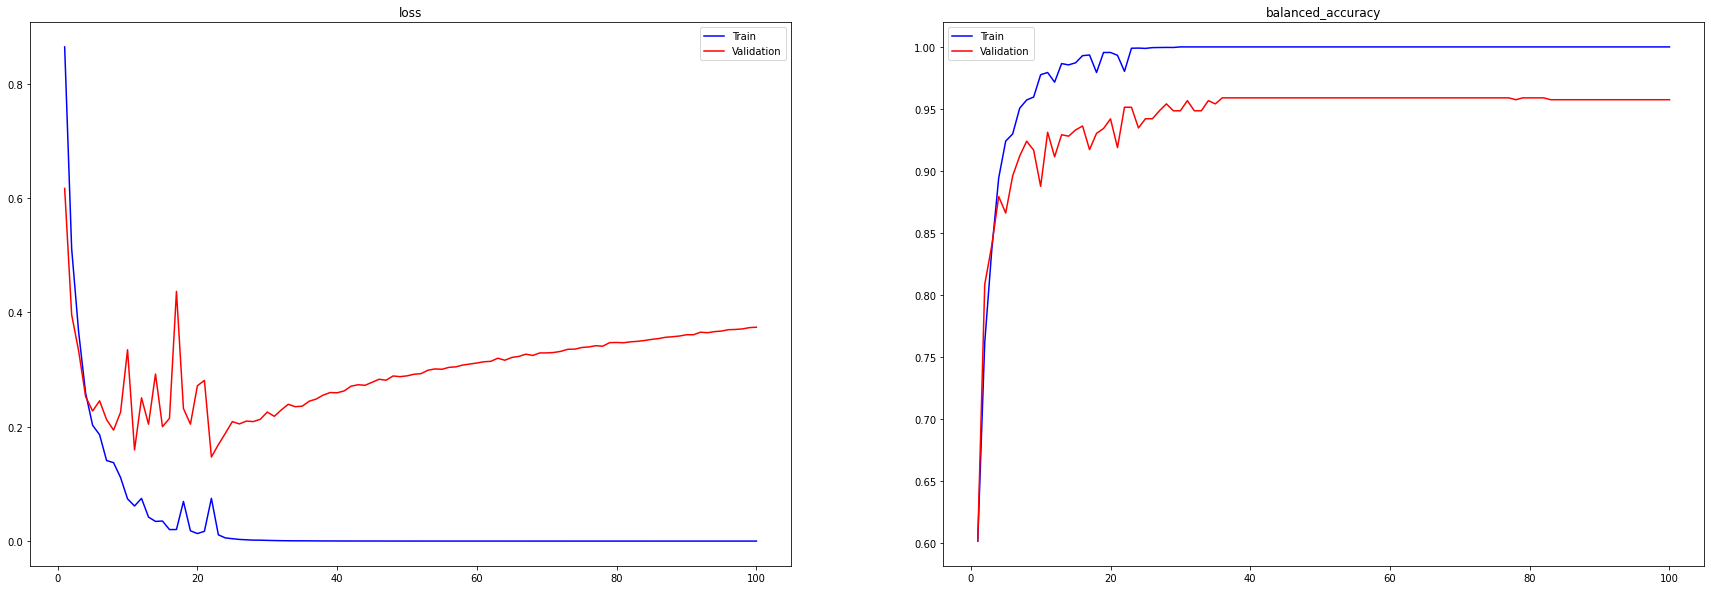

In [ ]:
graph_history(df_vgg_16, metrics_1, epochs=EPOCHS_2)
graph_history(df_vgg_16, metrics_2, epochs=EPOCHS_2)

In [ ]:
df_vgg_16.to_csv(f'{RES_PATH}/vgg_16_metrics_2.csv')

In [ ]:
res_lu_net, scores_lu_net = fit_evaluate(lu_net, X_train, X_test, X_val, y_val, y_train, y_test, epochs=EPOCHS_2)

Epoch 1/100
61/61 [==============================] - 9s 149ms/step - loss: 0.6467 - precision: 0.6974 - binary_accuracy: 0.6620 - recall: 0.5713 - balanced_accuracy: 0.6660 - val_loss: 0.5836 - val_precision: 0.7606 - val_binary_accuracy: 0.7052 - val_recall: 0.5934 - val_balanced_accuracy: 0.7031
Epoch 2/100
61/61 [==============================] - 8s 139ms/step - loss: 0.5272 - precision: 0.7906 - binary_accuracy: 0.7683 - recall: 0.7293 - balanced_accuracy: 0.7704 - val_loss: 0.5373 - val_precision: 0.7611 - val_binary_accuracy: 0.7464 - val_recall: 0.7137 - val_balanced_accuracy: 0.7413
Epoch 3/100
61/61 [==============================] - 8s 138ms/step - loss: 0.4769 - precision: 0.8332 - binary_accuracy: 0.8137 - recall: 0.7841 - balanced_accuracy: 0.8165 - val_loss: 0.5148 - val_precision: 0.8141 - val_binary_accuracy: 0.7608 - val_recall: 0.6722 - val_balanced_accuracy: 0.7615
Epoch 4/100
61/61 [==============================] - 8s 138ms/step - loss: 0.4375 - precision: 0.8626 -

In [ ]:
df_lu_net = pd.DataFrame(res_lu_net.history)
df_lu_net.head()

,loss,precision,binary_accuracy,recall,balanced_accuracy,val_loss,val_precision,val_binary_accuracy,val_recall,val_balanced_accuracy
0,0.646713,0.697352,0.662023,0.571281,0.665964,0.583634,0.760638,0.705155,0.593361,0.703060
1,0.527157,0.790594,0.768318,0.729339,0.770408,0.537316,0.761062,0.746392,0.713693,0.741299
2,0.476929,0.833150,0.813725,0.784091,0.816460,0.514759,0.814070,0.760825,0.672199,0.761459
3,0.437498,0.862620,0.851909,0.836777,0.852669,0.493485,0.805310,0.787629,0.755187,0.781926
4,0.409457,0.880259,0.864293,0.842975,0.862081,0.487482,0.834171,0.777320,0.688797,0.770399


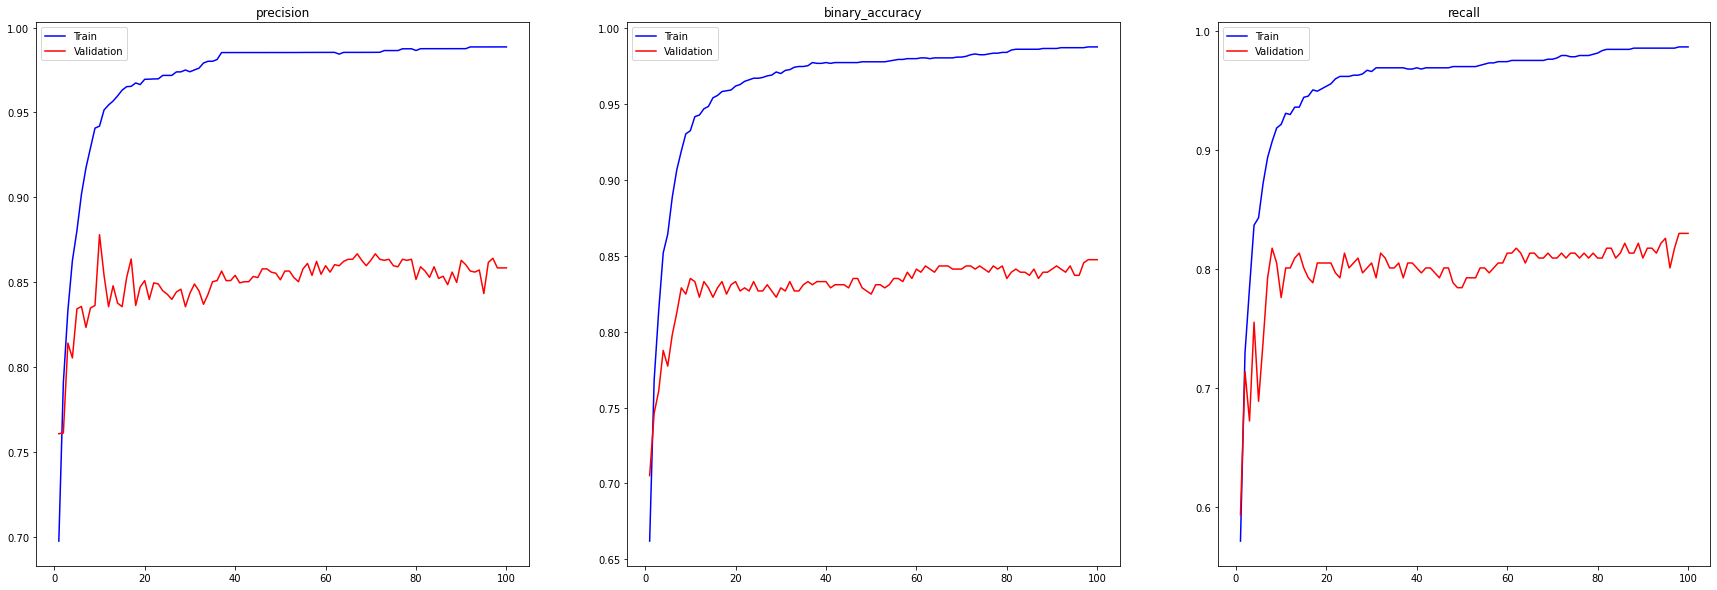

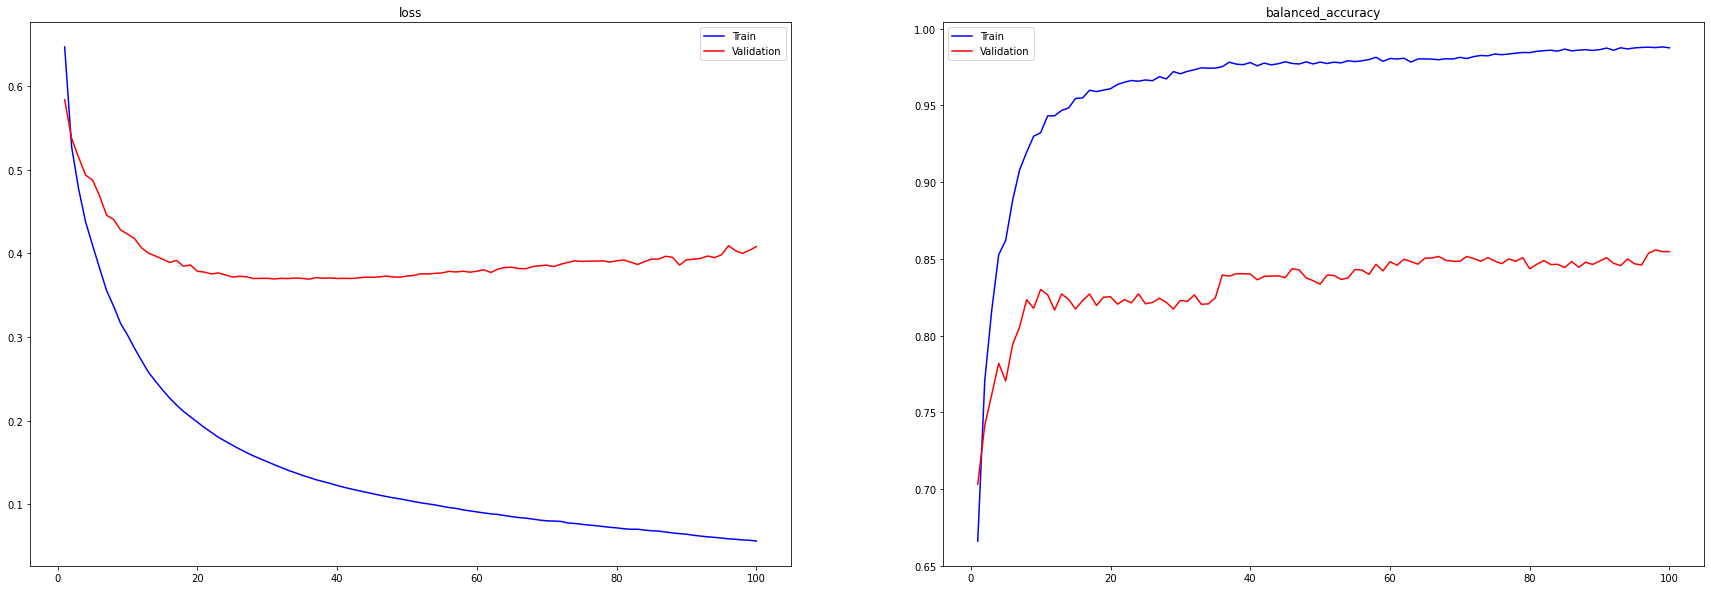

In [ ]:
graph_history(df_lu_net, metrics_1, epochs=EPOCHS_2)
graph_history(df_lu_net, metrics_2, epochs=EPOCHS_2)

In [ ]:
df_lu_net.to_csv(f'{RES_PATH}/lu_net_metrics_2.csv')

In [ ]:
scores = [scores_le_net, scores_vgg_16, scores_lu_net]
losses, precisions = [score[0] for score in scores], [score[1] for score in scores]
bin_accs, recalls = [score[2] for score in scores], [score[3] for score in scores]
baccs = [score[4] for score in scores]

scores_df = pd.DataFrame({
    'Loss':losses, 
    'Precision':precisions,
    'Binary Accuracy':bin_accs,
    'Recall':recalls,
    'Balanced Accuracy':baccs
}, index=['Le-Net 5', 'VGG-16', 'Lu-Net'])
scores_df.head()

,Loss,Precision,Binary Accuracy,Recall,Balanced Accuracy
Le-Net 5,0.252752,0.944664,0.920115,0.896811,0.923934
VGG-16,0.313741,0.977012,0.966314,0.956848,0.966458
Lu-Net,0.481651,0.841905,0.832531,0.829268,0.835098


In [ ]:
scores_df.to_csv(f'{RES_PATH}/test_scores_2.csv')

De los resultados obtenidos hasta el momento podemos extraer las siguientes conclusiones:

- **Las redes siguen presentando overfitting**. De nuevo, puede observarse como todas las redes alcanzan un valor perfecto de las diferentes métricas en el conjunto de entrenamiento. Sin embargo, en este segundo experimento observamos como las métricas en el conjunto de validación logran alcanzar valores más favorables, alcanzando por ejemplo un 95% de *accuracy* para la arquitectura VGG-16.

- **Crecimiento de la función de pérdida en el conjunto de validación**. Al igual que en el experimento previo, la función de pérdida en el conjunto de validación presenta un claro crecimiento, mientras que decrece en el caso del conjunto de entrenamiento. Como ya hemos visto, esto sugiere cierta incapacidad de nuestros modelos para generalizar y es síntoma de *overfitting*.

- **Se obtiene mejor rendimiento en el conjunto de *test***. En este caso, las métricas en el conjunto de *test* resultan mucho más favorables que en experimento anterior. Destaca una *accuracy* del 96.6% para la arquitectura VGG-16. 

En conclusión, este segundo experimiento ha permitido obtener unas métricas mucho más favorables con muestras no vistas duante el entrenamiento. Sin embargo, trataremos de mejorarlas aplicando ciertas técnicas de prevención del *overfitting*.

## Experimento 3: reducción del *overfitting* mediante regularización L2, capas Dropout y capas DropBlock

Como hemos visto en el subapartado anterior las redes siguen presentando cierto *overfitting* incluso aumentando de forma significativa el número de instancias en el *dataset*. Una posible forma de prevenir este sobre entrenamiento consiste en aplicar ciertas técnicas como la *regularización* o la inclusión de ciertos tipos de capas en nuestra red. Para los experimentos que mostraremos a continuación vamos a aplicar tres formas distintas de regularización:

- **Regularización L2**: la regularización de tipo L2 trata de evitar el *overfitting* introduciendo un término de regularización en la función de pérdida (*loss function*). Este término de regularización se define como la norma euclídea (o norma L2) de las matrices de pesos multiplicada por un factor de regularización *lambda* ($\lambda$). El grado de regularización vendrá determinado por el valor que tome este factor $\lambda$. Este tipo de regularización viene implementada por la clase ``L2`` del módulo ``tensorflow.keras.regularizers`` y utiliza un parámetro ``l2`` que en nuestros experimentos vendrá representado mediante la constante ``L2_VALUE``.

- **Capas *Dropout* para las capas completamente conectadas**: como ha podido verse, todas las arquitecturas empleadas presentan dos capas densamente conectadas antes de la capa de salida. Estas capas se caracterizan porque sus neuronas se encuentran conectadas con todas las neuronas de la capa predecesora. Incluir una capa Dropout entre estas capas densamente conectadas tendría un efecto similar a "eliminar" algunas neuronas, o lo que es lo mismo, no entrenar dichas neuronas. A nivel formal, sería equivalente a poner a 0s la columna correspondiente a cierta neurona en la matriz de pesos de su capa. La librería ``Keras`` implementa este tipo de capas mediante la clase ``Dropout`` del módulo ``tensorflow.keras.layers`` aceptando un parámetro ``rate`` indicativo de la probabilidad de que una neurona no sea entrenada.

- **Capas *Dropblock* para las capas convolucionales**: las capas *Dropblock* surgen como una alternativa a las capas *Dropout* en redes neuronales convolucionales. Esto es así porque la aplicación de capas *Dropout* en redes neuronales convolucionales tiene un efecto "inesperado". Este efecto es que no es equivalente a dejar de entrenar una neurona sino que alguno de los pesos correspondientes a la misma sí serán entrenados (esto se explicará más en detalle en la memoria correspondiente a este trabajo). Las capas *Dropblock* pueden entenderse por tanto como máscaras que se aplican sobre el *feature map* de cada capa convolucional que descarta algunas regiones contiguas, generando modelos más simples y, por tanto, reduciendo el *overfitting*.

En la memoria correspondiente a este trabajo se realizará una explicación más detallada de estas técnicas. Pasamos a continuación a examinar los resultados obtenidos.

In [ ]:
#X_yes, X_no, classes = load_dataset()
#X = np.row_stack((X_yes, X_no))
#N, SIZE_H, SIZE_V = X.shape
#N_CLASSES = len(np.unique(classes))
#print(f'X shape {X.shape}')
#print(f'Num classes: {N_CLASSES}')

In [ ]:
# imgs_trans = A.Compose([
#     A.HorizontalFlip(p=0.25),
#     A.VerticalFlip(p=0.25),
#     A.RandomBrightnessContrast(brightness_limit=(-0.2, 0.2), p=0.25),
#     A.Rotate(limit=[-20, 20], p=0.25, border_mode=cv2.BORDER_CONSTANT),
#     A.Affine(translate_percent=(-0.05, 0.05))
# ])

# N_AUG = 20
# n_yes = X_yes.shape[0]
# X_yes, y_yes = data_augmentation(X_yes, classes[:n_yes], 13, imgs_trans)
# X_yes, y_yes = np.array(X_yes), np.array(y_yes)
# X_no, y_no = data_augmentation(X_no, classes[n_yes:], N_AUG, imgs_trans)
# X_no, y_no = np.array(X_no), np.array(y_no)
# print(f'X_yes shape: {X_yes.shape}')
# print(f'X_no shape: {X_no.shape}')
# X = np.row_stack((X_yes, X_no))
# classes = np.concatenate((y_yes, y_no))
# # X, y = data_augmentation(X, classes, N_AUG, imgs_trans)
# # X, y = np.array(X), np.array(y)

# ss = StandardScaler()
# X_tmp = np.reshape(X, newshape=(X.shape[0], -1,))
# X_tmp = ss.fit_transform(X_tmp)
# X = np.reshape(X_tmp, newshape=(X.shape[0], SIZE_H, SIZE_V))
# print(f'X shape: {X.shape}')
# print(f'classes shape {classes.shape}')

In [ ]:
# sd = seed(time())
# X_train, X_test, y_train, y_test = train_test_split(X, classes, test_size=0.3, random_state=sd, shuffle=True)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=sd, shuffle=True)

# print(f'X_train shape: {X_train.shape}')
# print(f'y_train shape {y_train.shape}')
# print(f'X_val shape: {X_val.shape}')
# print(f'y_val shape {y_val.shape}')
# print(f'X_test shape: {X_test.shape}')
# print(f'y_test shape: {y_test.shape}')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 112, 112, 32)      832       
                                                                 
 drop_block2d (DropBlock2D)  (None, 112, 112, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 109, 109, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      51264     
                                                                 
 drop_block2d_1 (DropBlock2D  (None, 109, 109, 64)     0         
 )                                                               
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0

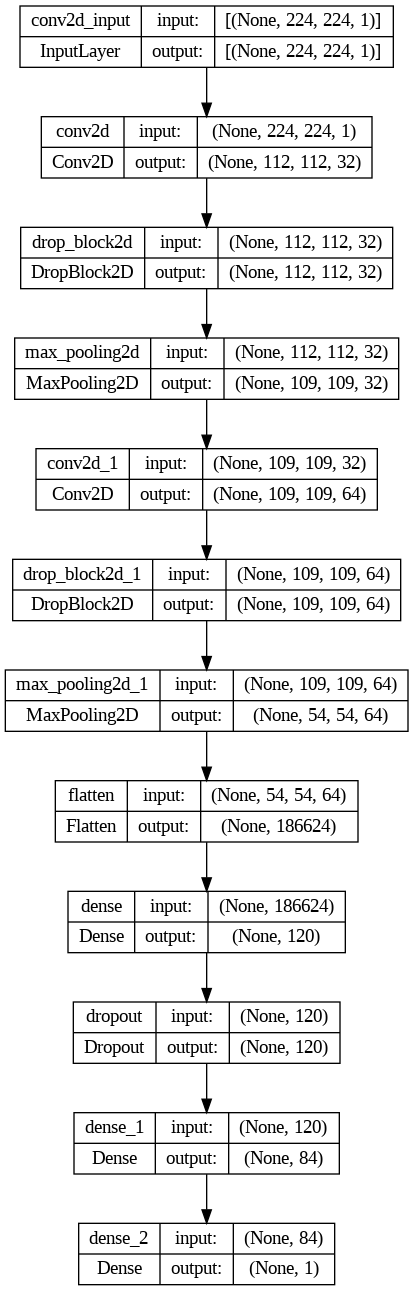

In [6]:
DROPOUT_RATE = 0.4
DROPBLOCK_RATE = 0.1
L2_VALUE = 0.01
le_net_5 = keras.Sequential([
    # LAYER 1
    Conv2D(filters=32, kernel_size=(5, 5), strides=2, padding="same", input_shape=(SIZE_H, SIZE_V, 1), activation='relu', kernel_regularizer=L2(L2_VALUE)),
    DropBlock2D(DROPBLOCK_RATE, block_size=(5, 5)),
    MaxPooling2D(pool_size=(4, 4), strides=1, padding="valid"),
    # LAYER 2
    Conv2D(filters=64, kernel_size=(5, 5), strides=1, padding="same", activation='relu', kernel_regularizer=L2(L2_VALUE)),
    DropBlock2D(DROPBLOCK_RATE, block_size=(5, 5)),
    MaxPooling2D(pool_size=(3, 3), strides=2, padding="valid"),
    # FLATTEN
    Flatten(),
    # DENSE LAYERS
    Dense(units=120, activation='relu'),
    Dropout(DROPOUT_RATE, seed=sd),
    Dense(units=84, activation='relu'),
    #Dropout(DROPOUT_RATE, seed=sd),
    # OUTPUT
    Dense(units=1, activation='sigmoid')
])

IMG_PATH = './images'
print(le_net_5.summary())
plot_model(le_net_5, to_file=f'{IMG_PATH}/le_net_5_dropout.png', show_shapes=True, show_layer_names=True)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 224, 224, 64)      640       
                                                                 
 drop_block2d_2 (DropBlock2D  (None, 224, 224, 64)     0         
 )                                                               
                                                                 
 conv2d_3 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 112, 112, 64)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 drop_block2d_3 (DropBlock2D  (None, 112, 112, 128)   

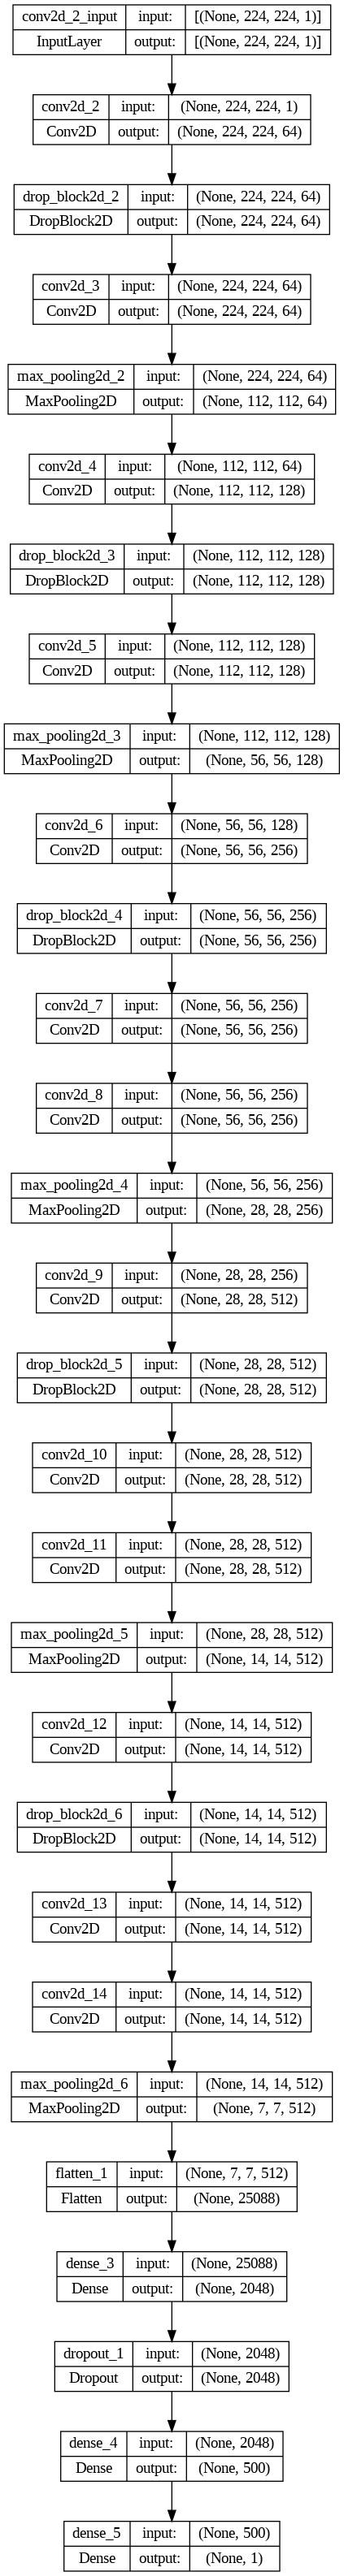

In [7]:
DROPOUT_RATE = 0.4
DROPBLOCK_RATE = 0.1
L2_VALUE = 0.001
vgg_16 = keras.Sequential([
    # LAYER 1
    Conv2D(filters=64, kernel_size=(3, 3), strides=1, padding='same', input_shape=(SIZE_H, SIZE_V, 1), activation='relu', kernel_regularizer=L2(L2_VALUE)),
    DropBlock2D(DROPBLOCK_RATE, block_size=(5, 5)),
    Conv2D(filters=64, kernel_size=(3, 3), strides=1, padding='same', activation='relu', kernel_regularizer=L2(L2_VALUE)),
    # LAYER 2
    MaxPooling2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=128, kernel_size=(3, 3), strides=1, padding='same', activation='relu', kernel_regularizer=L2(L2_VALUE)),
    DropBlock2D(DROPBLOCK_RATE, block_size=(5, 5)),
    Conv2D(filters=128, kernel_size=(3, 3), strides=1, padding='same', activation='relu', kernel_regularizer=L2(L2_VALUE)),
    # LAYER 3
    MaxPooling2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=256, kernel_size=(3, 3), strides=1, padding='same', activation='relu', kernel_regularizer=L2(L2_VALUE)),
    DropBlock2D(DROPBLOCK_RATE, block_size=(5, 5)),
    Conv2D(filters=256, kernel_size=(3, 3), strides=1, padding='same', activation='relu', kernel_regularizer=L2(L2_VALUE)),
    Conv2D(filters=256, kernel_size=(3, 3), strides=1, padding='same', activation='relu', kernel_regularizer=L2(L2_VALUE)),
    # LAYER 4
    MaxPooling2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=512, kernel_size=(3, 3), strides=1, padding='same', activation='relu', kernel_regularizer=L2(L2_VALUE)),
    DropBlock2D(DROPBLOCK_RATE, block_size=(5, 5)),
    Conv2D(filters=512, kernel_size=(3, 3), strides=1, padding='same', activation='relu', kernel_regularizer=L2(L2_VALUE)),
    Conv2D(filters=512, kernel_size=(3, 3), strides=1, padding='same', activation='relu', kernel_regularizer=L2(L2_VALUE)),
    # LAYER 5
    MaxPooling2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=512, kernel_size=(3, 3), strides=1, padding='same', activation='relu', kernel_regularizer=L2(L2_VALUE)),
    DropBlock2D(DROPBLOCK_RATE, block_size=(5, 5)),
    Conv2D(filters=512, kernel_size=(3, 3), strides=1, padding='same', activation='relu', kernel_regularizer=L2(L2_VALUE)),
    Conv2D(filters=512, kernel_size=(3, 3), strides=1, padding='same', activation='relu', kernel_regularizer=L2(L2_VALUE)),
    # MAXPOOL BEFORE FC
    MaxPooling2D(pool_size=(2, 2), strides=2),
    # FULLY CONNECTED LAYERS
    Flatten(),
    Dense(units=2048, activation='relu'),
    Dropout(DROPOUT_RATE, seed=sd),
    Dense(units=500, activation='relu'),
    # OUTPUT LAYER
    Dense(units=1, activation='sigmoid')
])

print(vgg_16.summary())
plot_model(vgg_16, to_file=f'{IMG_PATH}/vgg_16_dropout.png', show_shapes=True, show_layer_names=True)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 224, 224, 32)      320       
                                                                 
 drop_block2d_7 (DropBlock2D  (None, 224, 224, 32)     0         
 )                                                               
                                                                 
 conv2d_16 (Conv2D)          (None, 224, 224, 32)      9248      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 112, 112, 32)     0         
 2D)                                                             
                                                                 
 conv2d_17 (Conv2D)          (None, 112, 112, 64)      18496     
                                                                 
 drop_block2d_8 (DropBlock2D  (None, 112, 112, 64)    

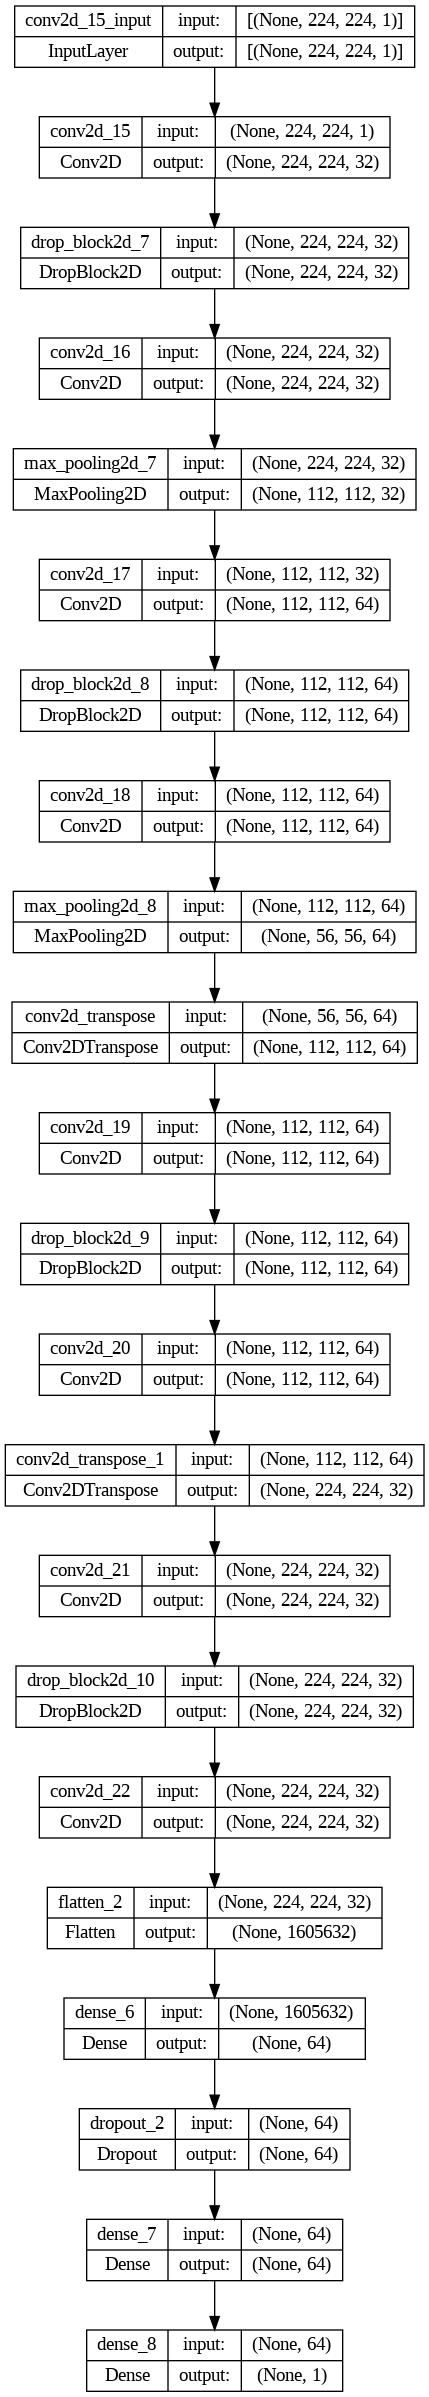

In [8]:
DROPOUT_RATE = 0.4
DROPBLOCK_RATE = 0.1
L2_VALUE = 0.001
lu_net = keras.Sequential([
    # LAYER 1
    Conv2D(filters=32, kernel_size=(3, 3), strides=1, padding='same', input_shape=(SIZE_H, SIZE_V, 1), activation='elu', kernel_regularizer=L2(L2_VALUE)),
    DropBlock2D(DROPBLOCK_RATE, block_size=(5, 5)),
    Conv2D(filters=32, kernel_size=(3, 3), strides=1, padding='same', activation='elu', kernel_regularizer=L2(L2_VALUE)),
    MaxPooling2D(pool_size=(2, 2), strides=2),
    # LAYER 2
    Conv2D(filters=64, kernel_size=(3, 3), strides=1, padding='same', activation='elu', kernel_regularizer=L2(L2_VALUE)),
    DropBlock2D(DROPBLOCK_RATE, block_size=(5, 5)),
    Conv2D(filters=64, kernel_size=(3, 3), strides=1, padding='same', activation='elu', kernel_regularizer=L2(L2_VALUE)),
    MaxPooling2D(pool_size=(2, 2), strides=2),
    # LAYER 3
    Conv2DTranspose(filters=64, kernel_size=(2, 2), strides=2, padding='same', activation='elu'),
    Conv2D(filters=64, kernel_size=(3, 3), strides=1, padding='same', activation='elu', kernel_regularizer=L2(L2_VALUE)),
    DropBlock2D(DROPBLOCK_RATE, block_size=(5, 5)),
    Conv2D(filters=64, kernel_size=(3, 3), strides=1, padding='same', activation='elu', kernel_regularizer=L2(L2_VALUE)),
    # LAYER 4
    Conv2DTranspose(filters=32, kernel_size=(2, 2), strides=2, padding='same', activation='elu'),
    Conv2D(filters=32, kernel_size=(3, 3), strides=1, padding='same', activation='elu', kernel_regularizer=L2(L2_VALUE)),
    DropBlock2D(DROPBLOCK_RATE, block_size=(5, 5)),
    Conv2D(filters=32, kernel_size=(3, 3), strides=1, padding='same', activation='elu', kernel_regularizer=L2(L2_VALUE)),
    # Fully connected layers
    Flatten(),
    Dense(units=64, activation='sigmoid'),
    Dropout(DROPOUT_RATE, seed=sd),
    Dense(units=64, activation='sigmoid'),
    # OUTPUT
    Dense(units=1, activation='sigmoid')
])

print(lu_net.summary())
plot_model(lu_net, to_file=f'{IMG_PATH}/lu_net_dropout.png', show_shapes=True, show_layer_names=True)

In [9]:
EPOCHS_3 = 100
RES_PATH = './results'
opt = keras.optimizers.legacy.Adam(learning_rate=1e-5)
METRICS = [
    Precision(),
    BinaryAccuracy(),
    Recall(),
    balanced_accuracy
]

le_net_5.compile(optimizer=opt, loss='binary_crossentropy', metrics=METRICS)
vgg_16.compile(optimizer=opt, loss='binary_crossentropy', metrics=METRICS)
lu_net.compile(optimizer=opt, loss='binary_crossentropy', metrics=METRICS)

In [ ]:
res_le_net, scores_le_net = fit_evaluate(le_net_5, X_train, X_test, X_val, y_val, y_train, y_test, epochs=EPOCHS_3)

Epoch 1/100
61/61 [==============================] - 20s 170ms/step - loss: 1.1006 - precision: 0.6085 - binary_accuracy: 0.5986 - recall: 0.5622 - balanced_accuracy: 0.5958 - val_loss: 1.0264 - val_precision: 0.7000 - val_binary_accuracy: 0.7340 - val_recall: 0.8434 - val_balanced_accuracy: 0.7226
Epoch 2/100
61/61 [==============================] - 9s 156ms/step - loss: 1.0157 - precision: 0.7162 - binary_accuracy: 0.7110 - recall: 0.7030 - balanced_accuracy: 0.7091 - val_loss: 0.9791 - val_precision: 0.8487 - val_binary_accuracy: 0.7052 - val_recall: 0.5181 - val_balanced_accuracy: 0.7131
Epoch 3/100
61/61 [==============================] - 9s 155ms/step - loss: 0.9365 - precision: 0.7779 - binary_accuracy: 0.7730 - recall: 0.7667 - balanced_accuracy: 0.7763 - val_loss: 0.9103 - val_precision: 0.8416 - val_binary_accuracy: 0.7979 - val_recall: 0.7470 - val_balanced_accuracy: 0.8033
Epoch 4/100
61/61 [==============================] - 9s 155ms/step - loss: 0.8672 - precision: 0.8138 

In [ ]:
df_le_net_5 = pd.DataFrame(res_le_net.history)
df_le_net_5.head()

,loss,precision,binary_accuracy,recall,balanced_accuracy,val_loss,val_precision,val_binary_accuracy,val_recall,val_balanced_accuracy
0,1.100614,0.608454,0.598555,0.562179,0.595839,1.026389,0.700000,0.734021,0.843373,0.722631
1,1.015691,0.716230,0.711042,0.702980,0.709101,0.979115,0.848684,0.705155,0.518072,0.713063
2,0.936478,0.777894,0.772962,0.766701,0.776281,0.910309,0.841629,0.797938,0.746988,0.803251
3,0.867226,0.813808,0.807534,0.799589,0.810310,0.864551,0.782456,0.818557,0.895582,0.805514
4,0.834041,0.829569,0.829205,0.830421,0.827639,0.831369,0.866953,0.839175,0.811245,0.825514


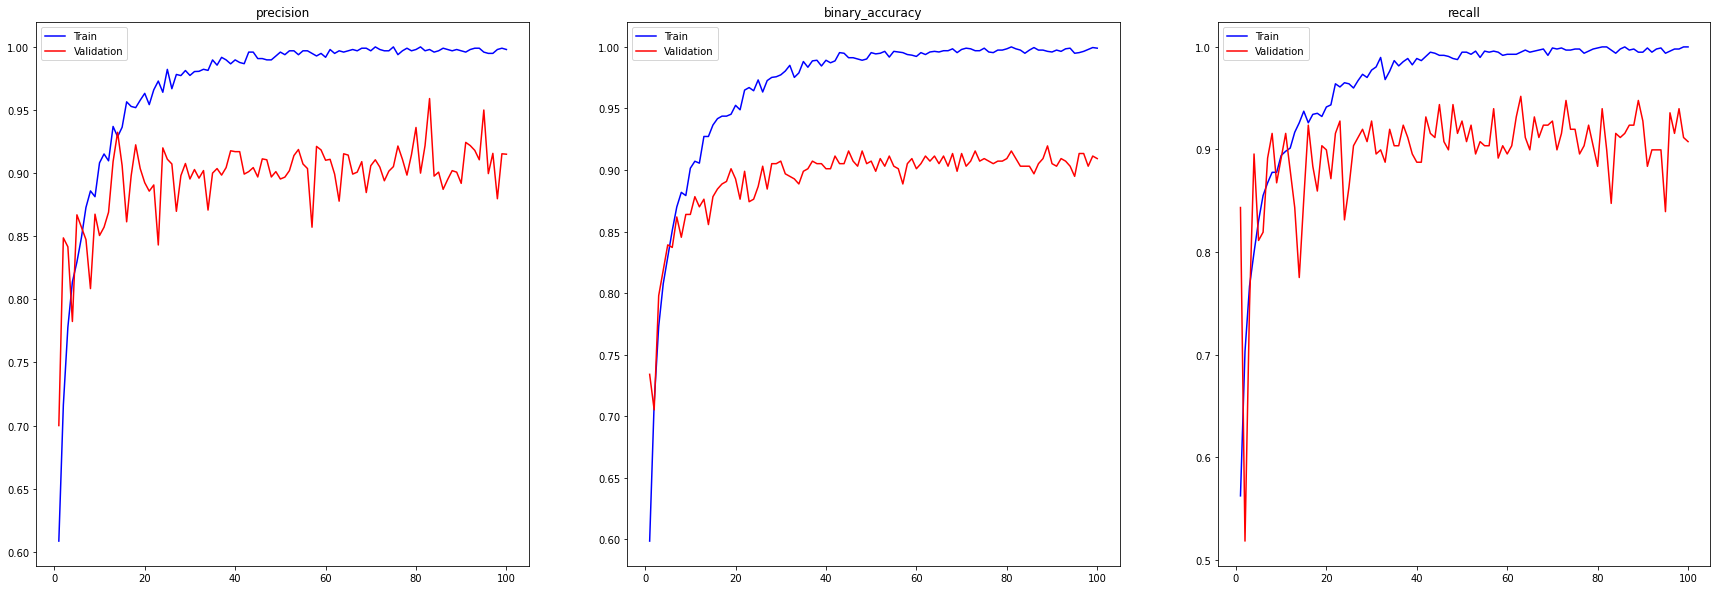

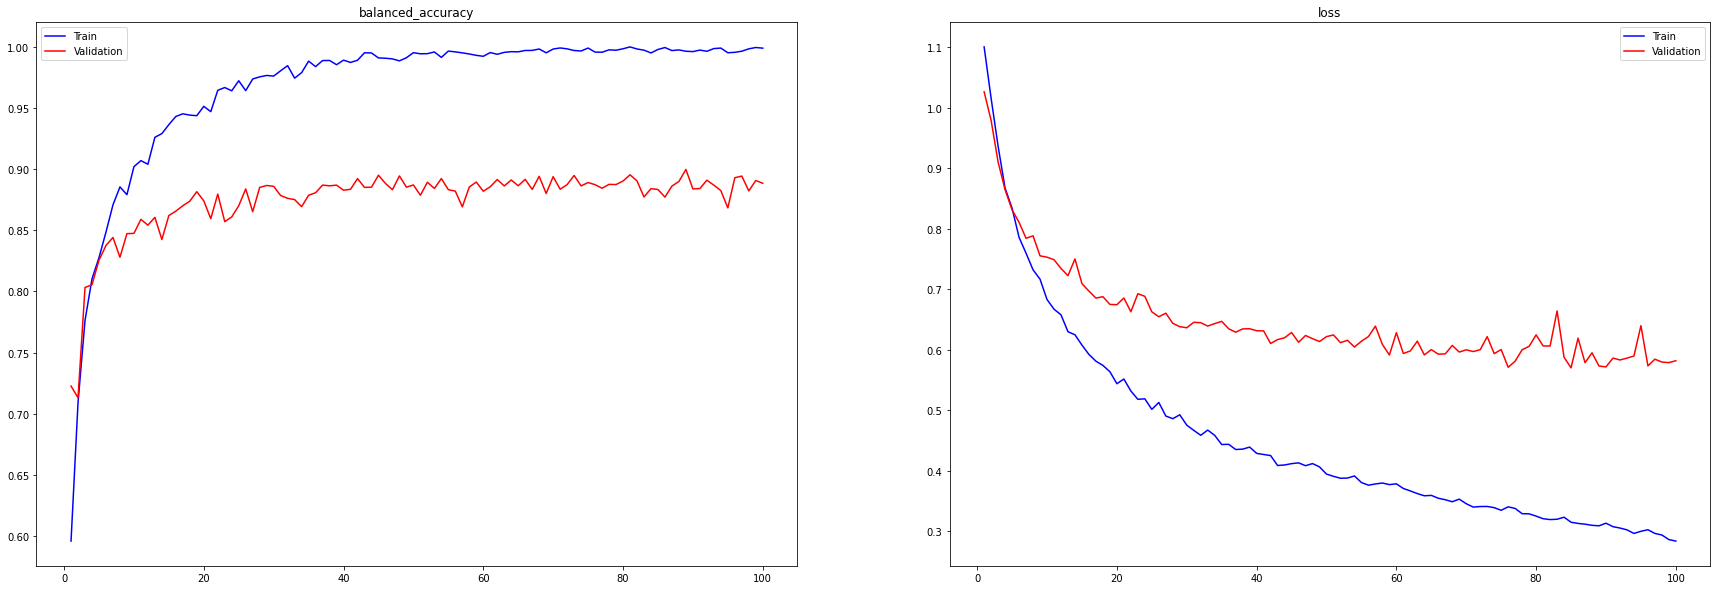

In [ ]:
metrics_1, metrics_2 = ['precision', 'binary_accuracy', 'recall'], ['balanced_accuracy', 'loss']
graph_history(df_le_net_5, metrics_1, epochs=EPOCHS_3)
graph_history(df_le_net_5, metrics_2, epochs=EPOCHS_3)

In [ ]:
df_le_net_5.to_csv(f'{RES_PATH}/le_net_5_metrics_3.csv')

In [ ]:
res_vgg_16, scores_vgg_16 = fit_evaluate(vgg_16, X_train, X_test, X_val, y_val, y_train, y_test, epochs=EPOCHS_3)

Epoch 1/100
61/61 [==============================] - 63s 928ms/step - loss: 4.0105 - precision: 0.6345 - binary_accuracy: 0.6631 - recall: 0.7743 - balanced_accuracy: 0.5189 - val_loss: 3.5291 - val_precision: 0.5134 - val_binary_accuracy: 0.5134 - val_recall: 1.0000 - val_balanced_accuracy: 0.5000
Epoch 2/100
61/61 [==============================] - 52s 848ms/step - loss: 3.2572 - precision: 0.5435 - binary_accuracy: 0.5697 - recall: 0.8921 - balanced_accuracy: 0.5699 - val_loss: 2.9962 - val_precision: 0.5721 - val_binary_accuracy: 0.6062 - val_recall: 0.9237 - val_balanced_accuracy: 0.5925
Epoch 3/100
61/61 [==============================] - 51s 844ms/step - loss: 2.8271 - precision: 0.6995 - binary_accuracy: 0.6796 - recall: 0.6341 - balanced_accuracy: 0.6847 - val_loss: 2.6419 - val_precision: 0.7936 - val_binary_accuracy: 0.7505 - val_recall: 0.6948 - val_balanced_accuracy: 0.7587
Epoch 4/100
61/61 [==============================] - 52s 850ms/step - loss: 2.5244 - precision: 0.80

In [ ]:
df_vgg_16 = pd.DataFrame(res_vgg_16.history)
df_vgg_16.head()

,loss,precision,binary_accuracy,recall,balanced_accuracy,val_loss,val_precision,val_binary_accuracy,val_recall,val_balanced_accuracy
0,4.010513,0.634468,0.663084,0.774280,0.518926,3.529054,0.513402,0.513402,1.000000,0.500000
1,3.257168,0.543519,0.569659,0.892086,0.569926,2.996246,0.572139,0.606186,0.923695,0.592500
2,2.827050,0.699546,0.679567,0.634121,0.684718,2.641920,0.793578,0.750515,0.694779,0.758744
3,2.524422,0.809886,0.750258,0.656732,0.753024,2.362703,0.908629,0.818557,0.718876,0.822611
4,2.298130,0.865764,0.804438,0.722508,0.806893,2.170201,0.946078,0.861856,0.775100,0.861492


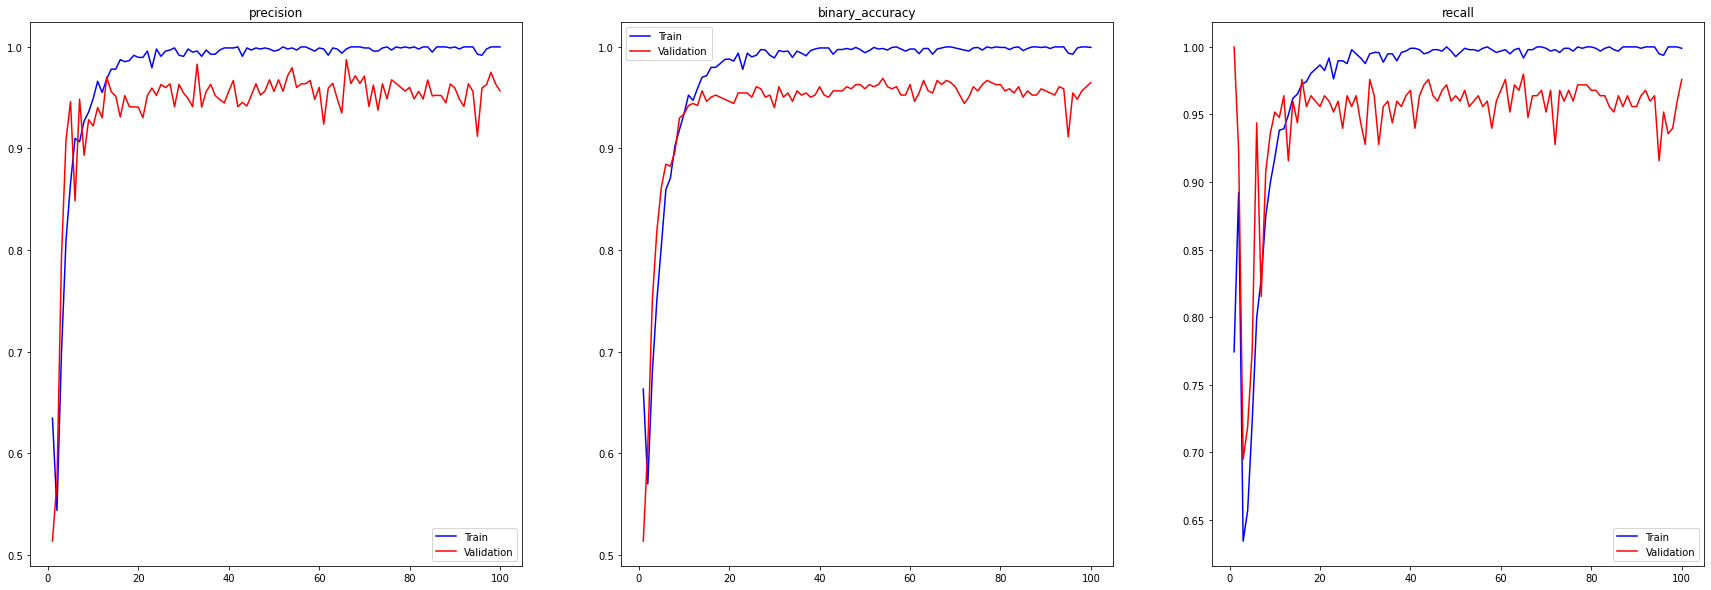

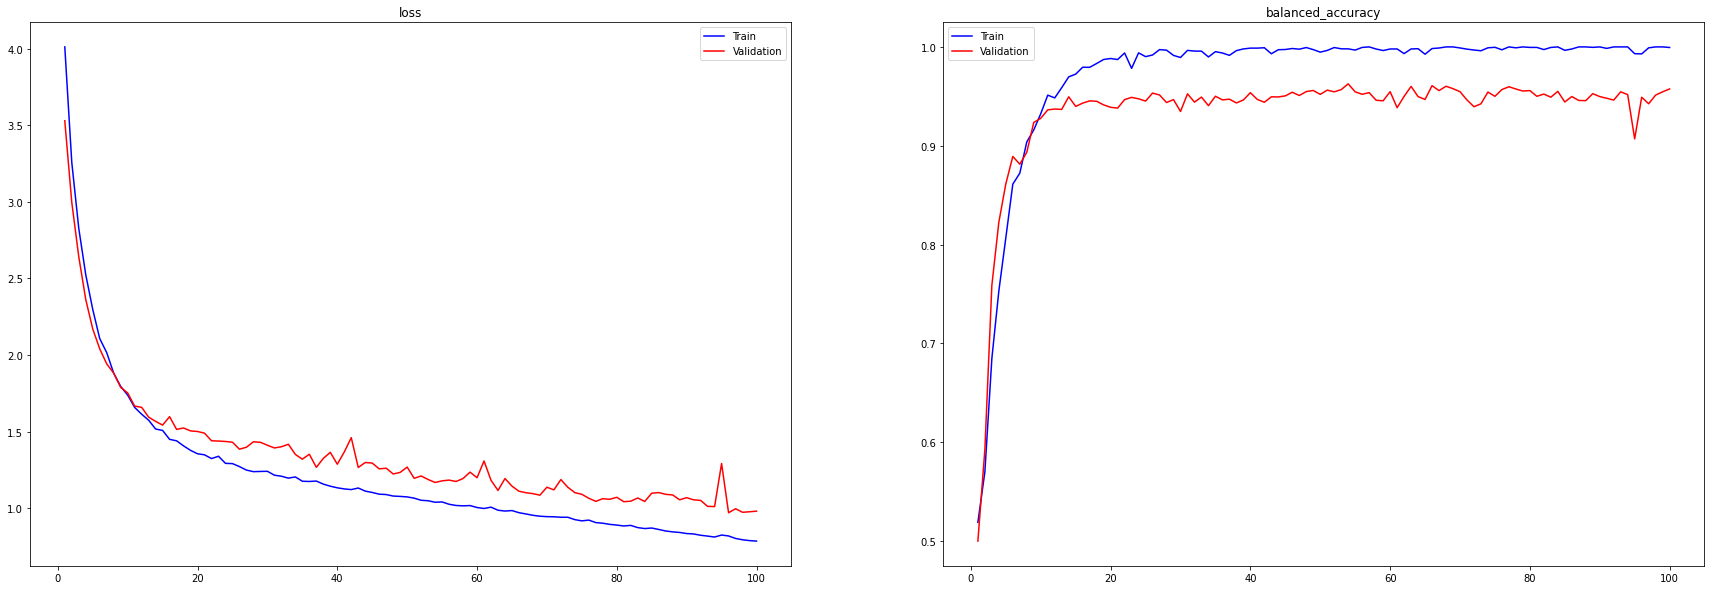

In [ ]:
metrics_1, metrics_2 = ['precision', 'binary_accuracy', 'recall'], ['loss', 'balanced_accuracy']
graph_history(df_vgg_16, metrics_1, epochs=EPOCHS_3)
graph_history(df_vgg_16, metrics_2, epochs=EPOCHS_3)

In [ ]:
df_vgg_16.to_csv(f'{RES_PATH}/vgg_16_metrics_3.csv')

In [ ]:
res_lu_net, scores_lu_net = fit_evaluate(lu_net, X_train, X_test, X_val, y_val, y_train, y_test, epochs=EPOCHS_3)

Epoch 1/100
61/61 [==============================] - 40s 628ms/step - loss: 1.0301 - precision: 0.6056 - binary_accuracy: 0.6574 - recall: 0.9082 - balanced_accuracy: 0.4963 - val_loss: 1.0063 - val_precision: 0.5134 - val_binary_accuracy: 0.5134 - val_recall: 1.0000 - val_balanced_accuracy: 0.5000
Epoch 2/100
61/61 [==============================] - 36s 597ms/step - loss: 1.0056 - precision: 0.4938 - binary_accuracy: 0.4881 - recall: 0.7718 - balanced_accuracy: 0.4869 - val_loss: 0.9908 - val_precision: 0.5134 - val_binary_accuracy: 0.5134 - val_recall: 1.0000 - val_balanced_accuracy: 0.5000
Epoch 3/100
61/61 [==============================] - 36s 596ms/step - loss: 0.9903 - precision: 0.5083 - binary_accuracy: 0.5093 - recall: 0.6917 - balanced_accuracy: 0.5098 - val_loss: 0.9782 - val_precision: 0.6077 - val_binary_accuracy: 0.6247 - val_recall: 0.7590 - val_balanced_accuracy: 0.6243
Epoch 4/100
61/61 [==============================] - 36s 598ms/step - loss: 0.9765 - precision: 0.50

In [ ]:
df_lu_net = pd.DataFrame(res_lu_net.history)
df_lu_net.head()

,loss,precision,binary_accuracy,recall,balanced_accuracy,val_loss,val_precision,val_binary_accuracy,val_recall,val_balanced_accuracy
0,1.030147,0.605628,0.657373,0.908238,0.496261,1.006348,0.513402,0.513402,1.000000,0.500000
1,1.005584,0.493754,0.488132,0.771840,0.486868,0.990842,0.513402,0.513402,1.000000,0.500000
2,0.990342,0.508308,0.509288,0.691675,0.509788,0.978244,0.607717,0.624742,0.759036,0.624301
3,0.976545,0.501590,0.500000,0.648510,0.500392,0.967167,0.802721,0.670103,0.473896,0.679900
4,0.966355,0.506287,0.505676,0.620761,0.503383,0.956906,0.782609,0.593814,0.289157,0.600380


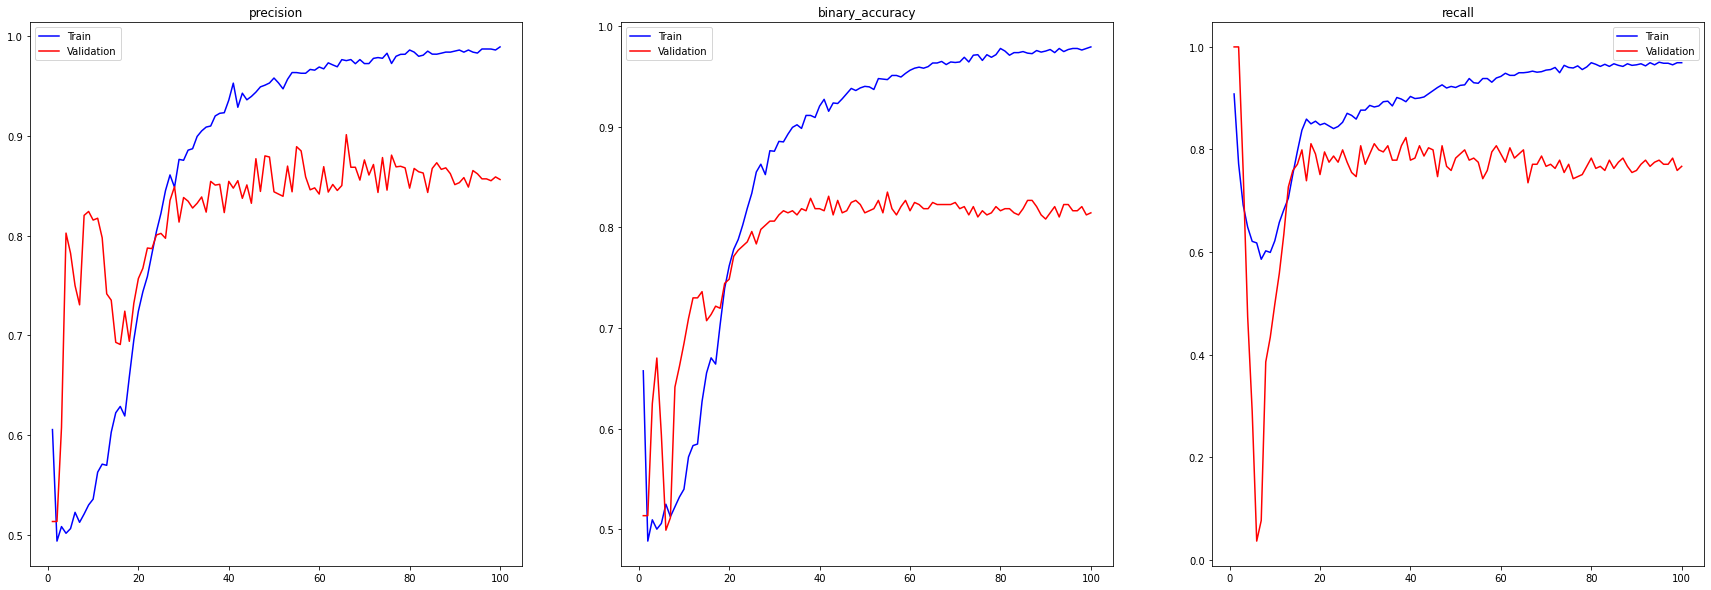

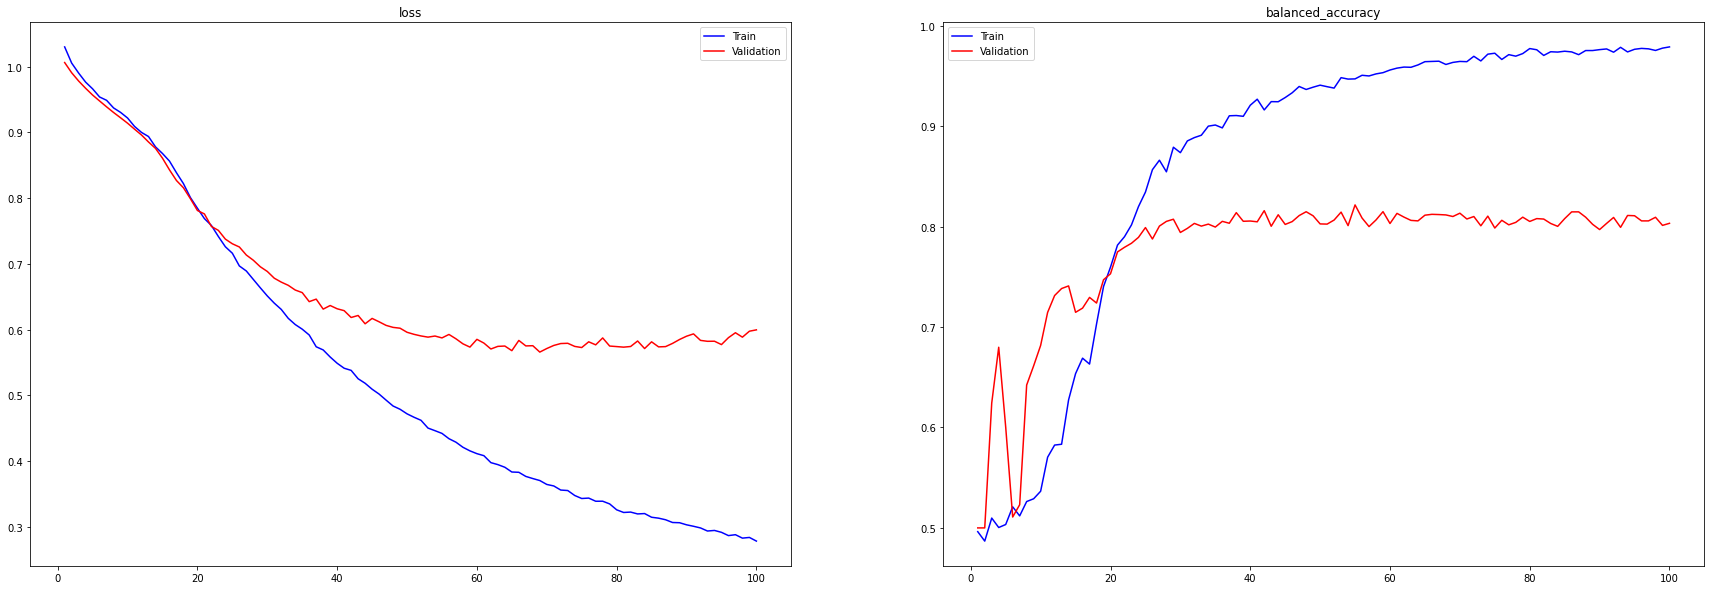

In [ ]:
metrics_1, metrics_2 = ['precision', 'binary_accuracy', 'recall'], ['loss', 'balanced_accuracy']
graph_history(df_lu_net, metrics_1, epochs=EPOCHS_3)
graph_history(df_lu_net, metrics_2, epochs=EPOCHS_3)

In [ ]:
df_lu_net.to_csv(f'{RES_PATH}/lu_net_metrics_3.csv')

In [ ]:
scores = [scores_le_net, scores_vgg_16, scores_lu_net]
losses, precisions = [score[0] for score in scores], [score[1] for score in scores]
bin_accs, recalls = [score[2] for score in scores], [score[3] for score in scores]
baccs = [score[4] for score in scores]

scores_df = pd.DataFrame({
    'Loss':losses, 
    'Precision':precisions,
    'Binary Accuracy':bin_accs,
    'Recall':recalls,
    'Balanced Accuracy':baccs
}, index=['Le-Net 5', 'VGG-16', 'Lu-Net'])
scores_df.head()

,Loss,Precision,Binary Accuracy,Recall,Balanced Accuracy
Le-Net 5,0.500515,0.951710,0.931665,0.909615,0.934694
VGG-16,1.056155,0.950758,0.957652,0.965385,0.957267
Lu-Net,0.520429,0.904867,0.851781,0.786538,0.857214


In [ ]:
scores_df.to_csv(f'{RES_PATH}/test_scores_3.csv')

De los resultados obtenidos podemos interpretar lo siguiente:

- **Se produce una reducción notable del *overfitting***: las arquitecturas Le-Net 5 y VGG-16

## More data augmentation and regularization

In [10]:
X_yes, X_no, classes = load_dataset()
X = np.row_stack((X_yes, X_no))
N, SIZE_H, SIZE_V = X.shape
N_CLASSES = len(np.unique(classes))
print(f'X shape {X.shape}')
print(f'Num classes: {N_CLASSES}')

X_yes shape: (134, 224, 224)
X_no shape (86, 224, 224)
classes shape: (220,)
X shape (220, 224, 224)
Num classes: 2


In [11]:
imgs_trans = A.Compose([
    A.HorizontalFlip(p=0.25),
    A.VerticalFlip(p=0.25),
    A.RandomBrightnessContrast(brightness_limit=(-0.2, 0.2), p=0.25),
    A.Rotate(limit=[-20, 20], p=0.25, border_mode=cv2.BORDER_CONSTANT),
    A.Affine(translate_percent=(-0.05, 0.05))
])

N_AUG_NO = 40
N_AUG_YES = np.ceil((N_AUG_NO * X_no.shape[0]) / X_yes.shape[0]).astype(int)
X, classes = data_augmentation_with_class(X, classes, N_AUG_YES, N_AUG_NO, imgs_trans)
X, classes = np.array(X), np.array(classes)

#n_yes = X_yes.shape[0]
#X_yes, y_yes = data_augmentation(X_yes, classes[:n_yes], N_AUG_YES, imgs_trans)
#X_yes, y_yes = np.array(X_yes), np.array(y_yes)
#X_no, y_no = data_augmentation(X_no, classes[n_yes:], N_AUG_NO, imgs_trans)
#X_no, y_no = np.array(X_no), np.array(y_no)
#print(f'X_yes shape: {X_yes.shape}')
#print(f'X_no shape: {X_no.shape}')
#X = np.row_stack((X_yes, X_no))
#classes = np.concatenate((y_yes, y_no))

ss = StandardScaler()
X_tmp = np.reshape(X, newshape=(X.shape[0], -1,))
X_tmp = ss.fit_transform(X_tmp)

X = np.reshape(X_tmp, newshape=(X.shape[0], SIZE_H, SIZE_V))
print(f'X shape: {X.shape}')
print(f'classes shape {classes.shape}')

[!] 50 images agumented...
[!] 100 images agumented...
[!] 150 images agumented...
[!] 200 images agumented...
[!] Total of 220 images augmented!

X shape: (6924, 224, 224)
classes shape (6924,)


In [12]:
#sd = seed(time())
X_train, X_test, y_train, y_test = train_test_split(X, classes, test_size=0.3, random_state=sd, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=sd, shuffle=True)

print(f'X_train shape: {X_train.shape}')
print(f'y_train shape {y_train.shape}')
print(f'X_val shape: {X_val.shape}')
print(f'y_val shape {y_val.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (3876, 224, 224)
y_train shape (3876,)
X_val shape: (970, 224, 224)
y_val shape (970,)
X_test shape: (2078, 224, 224)
y_test shape: (2078,)


In [21]:
res_le_net, scores_le_net = fit_evaluate(le_net_5, X_train, X_test, X_val, y_val, y_train, y_test, epochs=EPOCHS_3)

Epoch 1/100
61/61 [==============================] - 11s 172ms/step - loss: 1.1059 - precision: 0.7033 - binary_accuracy: 0.6943 - recall: 0.6837 - balanced_accuracy: 0.6053 - val_loss: 1.0273 - val_precision: 0.7014 - val_binary_accuracy: 0.7505 - val_recall: 0.8523 - val_balanced_accuracy: 0.7278
Epoch 2/100
61/61 [==============================] - 10s 166ms/step - loss: 0.9706 - precision: 0.7315 - binary_accuracy: 0.7276 - recall: 0.7225 - balanced_accuracy: 0.7314 - val_loss: 0.9254 - val_precision: 0.8659 - val_binary_accuracy: 0.7588 - val_recall: 0.5992 - val_balanced_accuracy: 0.7455
Epoch 3/100
61/61 [==============================] - 10s 163ms/step - loss: 0.8767 - precision: 0.8004 - binary_accuracy: 0.7884 - recall: 0.7708 - balanced_accuracy: 0.7914 - val_loss: 0.8651 - val_precision: 0.7465 - val_binary_accuracy: 0.8000 - val_recall: 0.8945 - val_balanced_accuracy: 0.8085
Epoch 4/100
61/61 [==============================] - 12s 195ms/step - loss: 0.8127 - precision: 0.82

In [22]:
df_le_net_5 = pd.DataFrame(res_le_net.history)
df_le_net_5.head()

,loss,precision,binary_accuracy,recall,balanced_accuracy,val_loss,val_precision,val_binary_accuracy,val_recall,val_balanced_accuracy
0,1.105873,0.703349,0.694323,0.683721,0.605338,1.027318,0.701389,0.750515,0.852321,0.727832
1,0.970602,0.731530,0.727554,0.722508,0.731417,0.925425,0.865854,0.758763,0.599156,0.745510
2,0.876693,0.800427,0.788442,0.770812,0.791404,0.865116,0.746479,0.800000,0.894515,0.808509
3,0.812689,0.829744,0.829721,0.831449,0.832174,0.813488,0.768382,0.812371,0.881857,0.804282
4,0.757795,0.855208,0.849845,0.843782,0.850748,0.768945,0.877451,0.828866,0.755274,0.821098


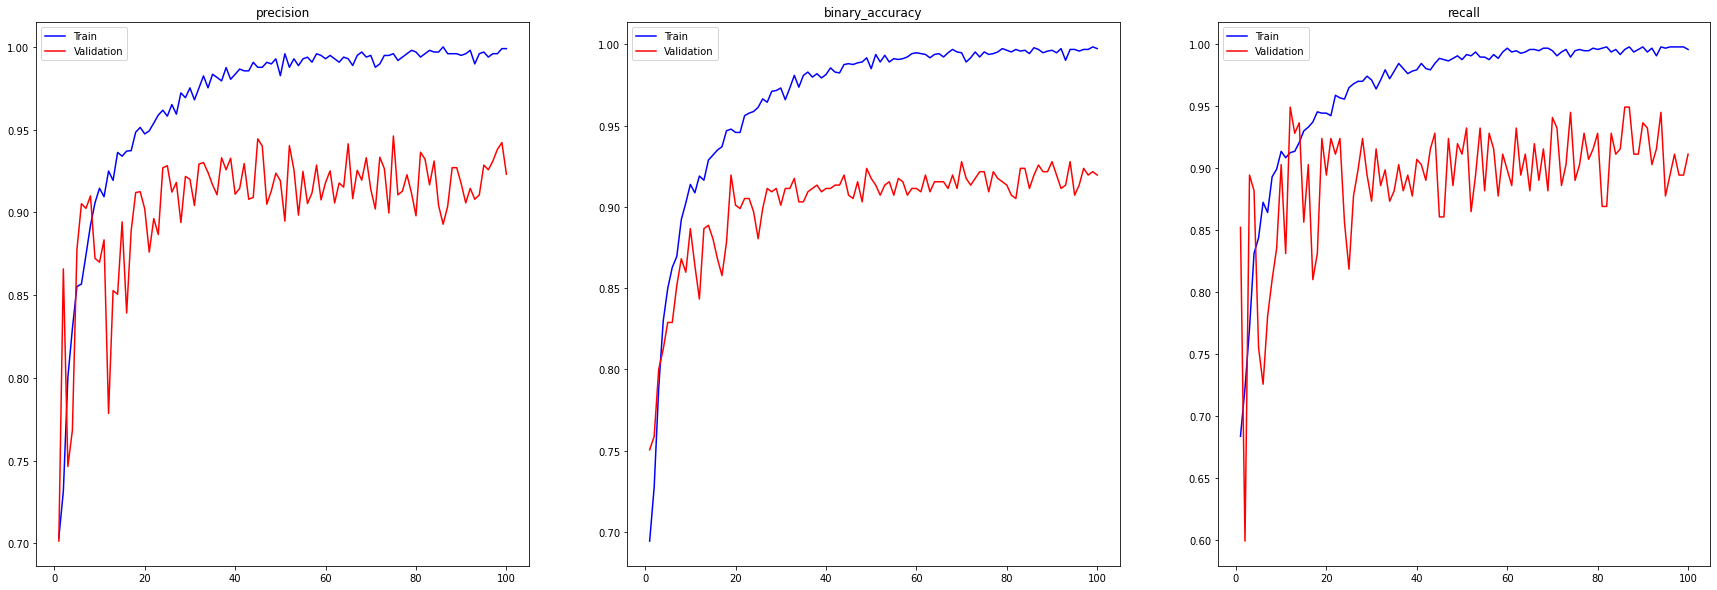

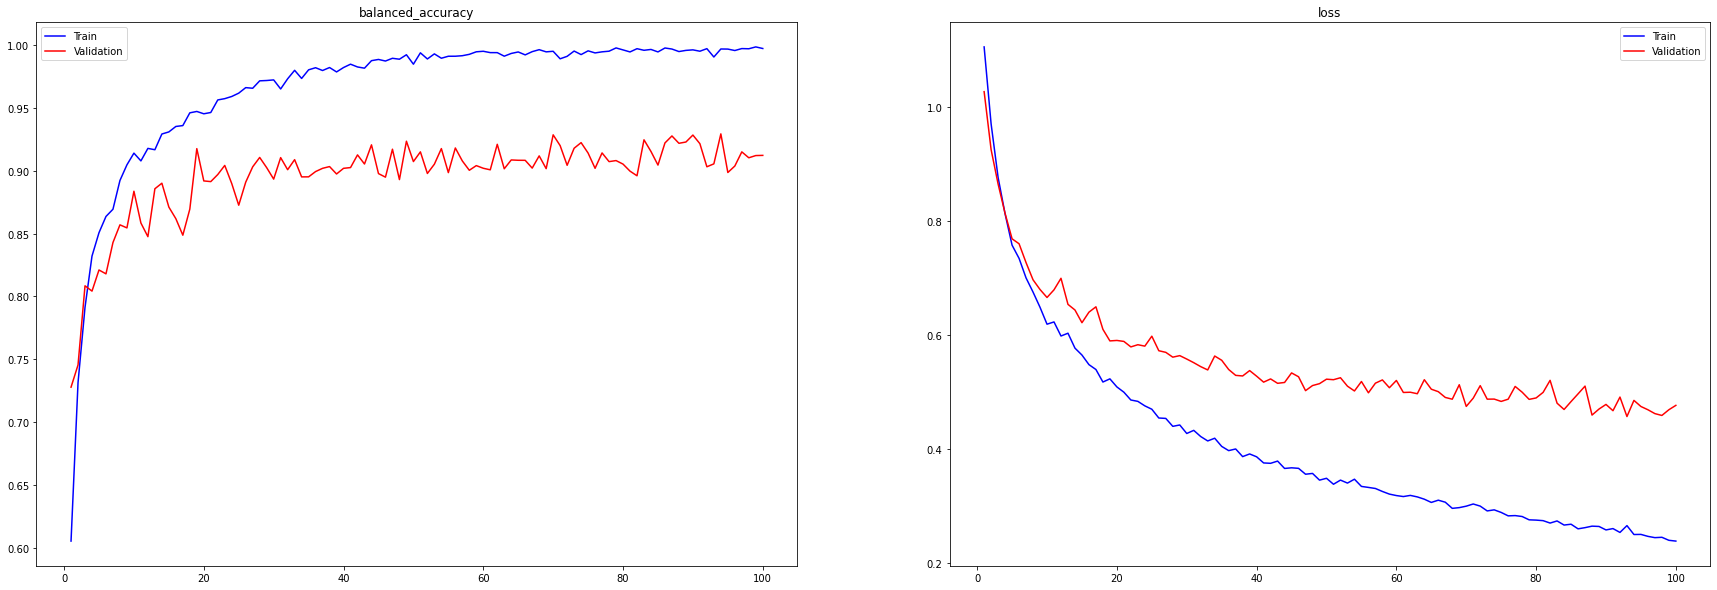

In [23]:
metrics_1, metrics_2 = ['precision', 'binary_accuracy', 'recall'], ['balanced_accuracy', 'loss']
graph_history(df_le_net_5, metrics_1, epochs=EPOCHS_3)
graph_history(df_le_net_5, metrics_2, epochs=EPOCHS_3)

In [24]:
df_le_net_5.to_csv(f'{RES_PATH}/le_net_5_metrics_4.csv')

In [10]:
res_vgg_16, scores_vgg_16 = fit_evaluate(vgg_16, X_train, X_test, X_val, y_val, y_train, y_test, epochs=EPOCHS_3)

Epoch 1/100
61/61 [==============================] - 74s 967ms/step - loss: 4.4537 - precision: 0.5392 - binary_accuracy: 0.5299 - recall: 0.4378 - balanced_accuracy: 0.5189 - val_loss: 4.3459 - val_precision: 0.4887 - val_binary_accuracy: 0.4887 - val_recall: 1.0000 - val_balanced_accuracy: 0.5000
Epoch 2/100
61/61 [==============================] - 54s 888ms/step - loss: 4.2477 - precision: 0.5021 - binary_accuracy: 0.5021 - recall: 1.0000 - balanced_accuracy: 0.5000 - val_loss: 4.1459 - val_precision: 0.5363 - val_binary_accuracy: 0.5753 - val_recall: 0.9662 - val_balanced_accuracy: 0.5790
Epoch 3/100
61/61 [==============================] - 54s 886ms/step - loss: 4.0164 - precision: 0.6331 - binary_accuracy: 0.6465 - recall: 0.7040 - balanced_accuracy: 0.6443 - val_loss: 3.8677 - val_precision: 0.6814 - val_binary_accuracy: 0.7320 - val_recall: 0.8481 - val_balanced_accuracy: 0.7351
Epoch 4/100
61/61 [==============================] - 54s 886ms/step - loss: 3.8089 - precision: 0.73

In [11]:
df_vgg_16 = pd.DataFrame(res_vgg_16.history)
df_vgg_16.head()

,loss,precision,binary_accuracy,recall,balanced_accuracy,val_loss,val_precision,val_binary_accuracy,val_recall,val_balanced_accuracy
0,4.453700,0.539240,0.529928,0.437821,0.518876,4.345910,0.488660,0.488660,1.000000,0.500000
1,4.247714,0.502064,0.502064,1.000000,0.500000,4.145924,0.536300,0.575258,0.966245,0.579010
2,4.016374,0.633087,0.646543,0.704008,0.644287,3.867678,0.681356,0.731959,0.848101,0.735076
3,3.808875,0.737124,0.726006,0.706064,0.728045,3.688247,0.791489,0.793814,0.784810,0.782174
4,3.635387,0.813541,0.789474,0.753340,0.788394,3.538011,0.913043,0.824742,0.708861,0.817182


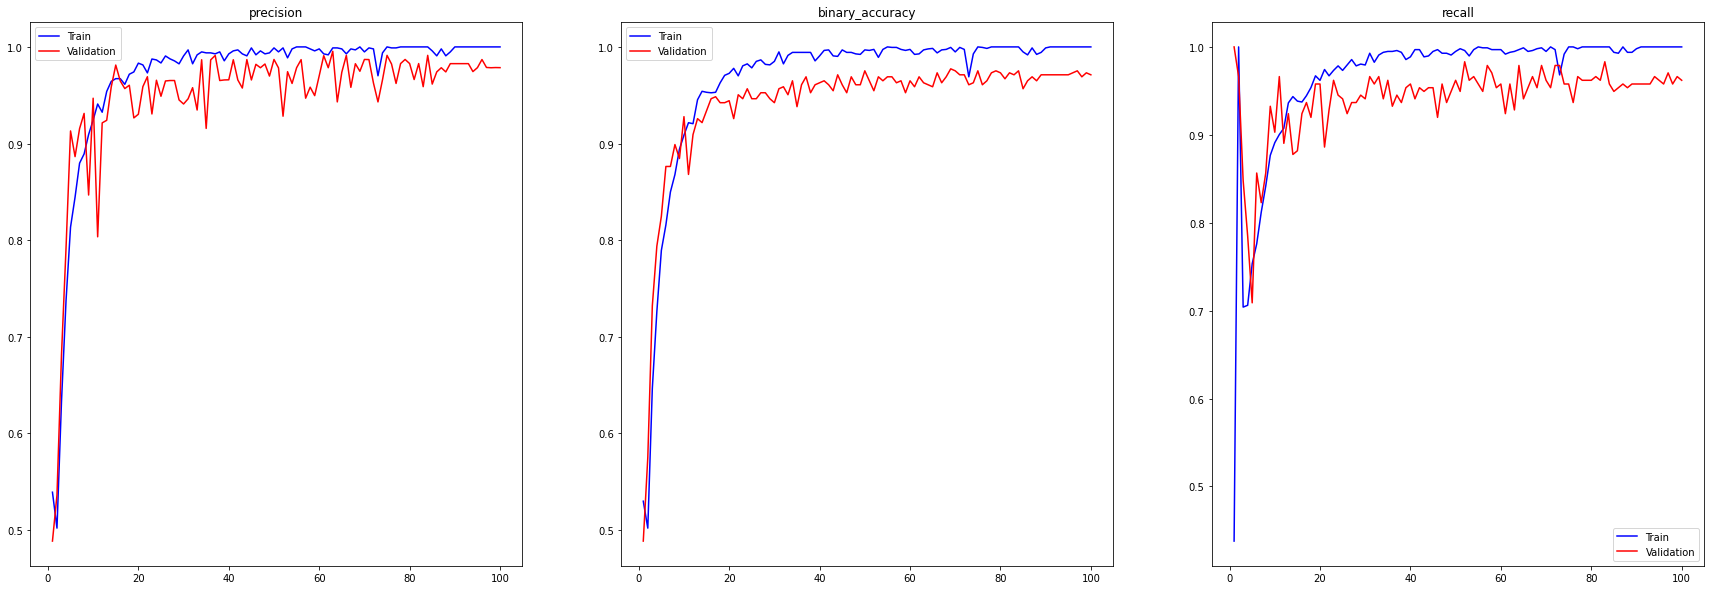

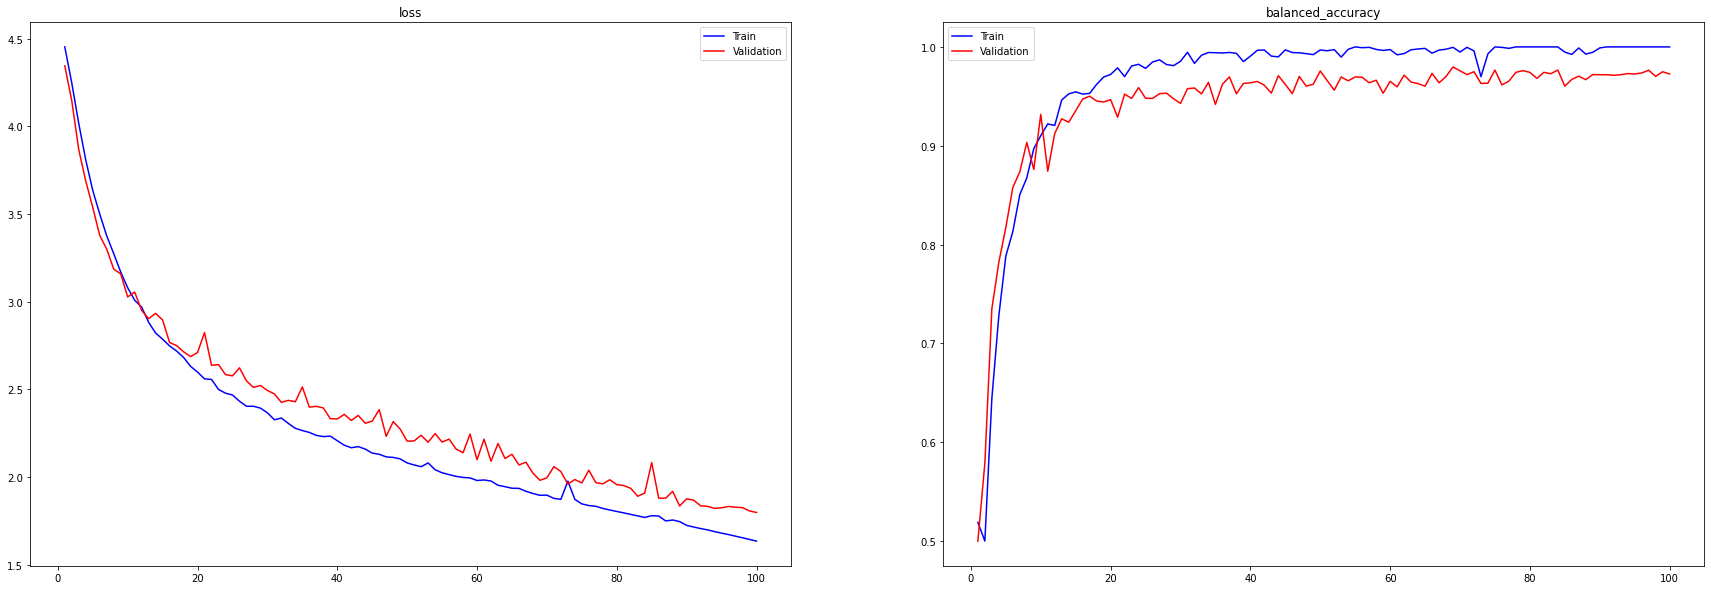

In [12]:
metrics_1, metrics_2 = ['precision', 'binary_accuracy', 'recall'], ['loss', 'balanced_accuracy']
graph_history(df_vgg_16, metrics_1, epochs=EPOCHS_3)
graph_history(df_vgg_16, metrics_2, epochs=EPOCHS_3)

In [13]:
df_vgg_16.to_csv(f'{RES_PATH}/vgg_16_metrics_4.csv')

In [14]:
res_lu_net, scores_lu_net = fit_evaluate(lu_net, X_train, X_test, X_val, y_val, y_train, y_test, epochs=EPOCHS_3)

Epoch 1/100
61/61 [==============================] - 42s 658ms/step - loss: 0.9769 - precision: 0.7597 - binary_accuracy: 0.7551 - recall: 0.7542 - balanced_accuracy: 0.6367 - val_loss: 0.9572 - val_precision: 0.6314 - val_binary_accuracy: 0.6598 - val_recall: 0.7300 - val_balanced_accuracy: 0.6619
Epoch 2/100
61/61 [==============================] - 38s 627ms/step - loss: 0.9139 - precision: 0.7238 - binary_accuracy: 0.7270 - recall: 0.7379 - balanced_accuracy: 0.7321 - val_loss: 0.9032 - val_precision: 0.7249 - val_binary_accuracy: 0.7237 - val_recall: 0.7004 - val_balanced_accuracy: 0.7347
Epoch 3/100
61/61 [==============================] - 38s 627ms/step - loss: 0.8629 - precision: 0.7843 - binary_accuracy: 0.7781 - recall: 0.7698 - balanced_accuracy: 0.7757 - val_loss: 0.8754 - val_precision: 0.7564 - val_binary_accuracy: 0.7588 - val_recall: 0.7468 - val_balanced_accuracy: 0.7661
Epoch 4/100
61/61 [==============================] - 38s 625ms/step - loss: 0.8245 - precision: 0.80

In [15]:
df_lu_net = pd.DataFrame(res_lu_net.history)
df_lu_net.head()

,loss,precision,binary_accuracy,recall,balanced_accuracy,val_loss,val_precision,val_binary_accuracy,val_recall,val_balanced_accuracy
0,0.976935,0.759705,0.755123,0.754153,0.636671,0.957227,0.631387,0.659794,0.729958,0.661906
1,0.913867,0.723790,0.727038,0.737924,0.732098,0.903191,0.724891,0.723711,0.700422,0.734655
2,0.862885,0.784293,0.778122,0.769784,0.775665,0.875403,0.756410,0.758763,0.746835,0.766078
3,0.824516,0.808233,0.814757,0.827338,0.816529,0.853688,0.786667,0.777320,0.746835,0.782774
4,0.790803,0.834350,0.837461,0.843782,0.836196,0.826334,0.801802,0.787629,0.751055,0.792440


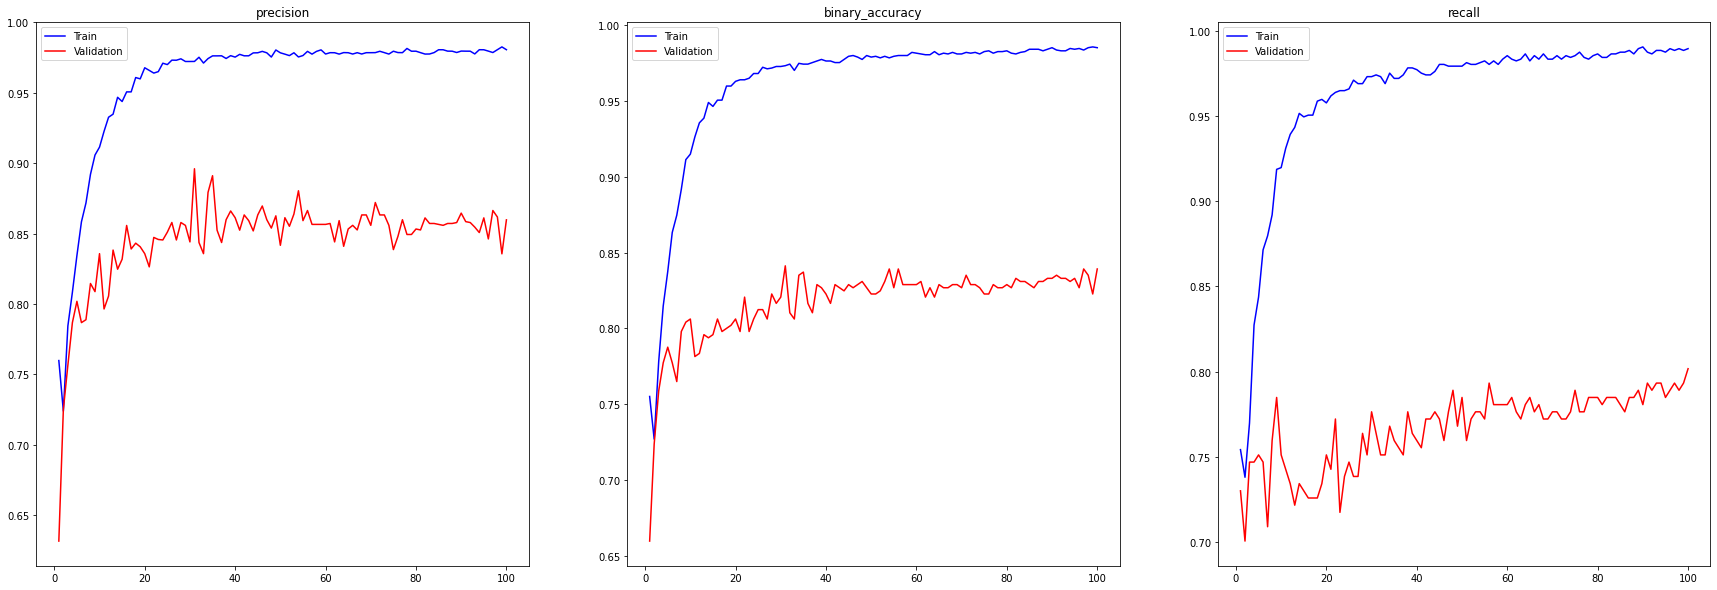

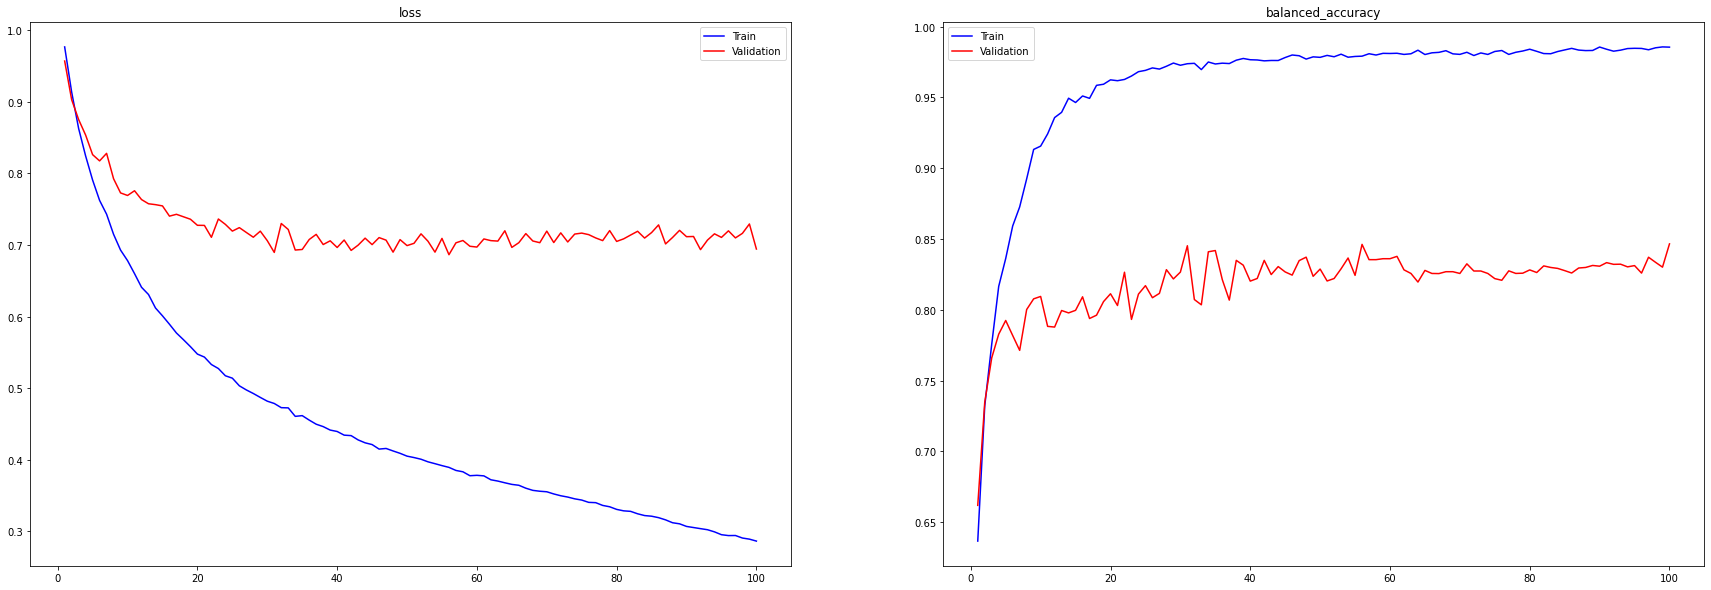

In [17]:
metrics_1, metrics_2 = ['precision', 'binary_accuracy', 'recall'], ['loss', 'balanced_accuracy']
graph_history(df_lu_net, metrics_1, epochs=EPOCHS_3)
graph_history(df_lu_net, metrics_2, epochs=EPOCHS_3)

In [18]:
df_lu_net.to_csv(f'{RES_PATH}/lu_net_metrics_4.csv')

In [25]:
scores = [scores_le_net, scores_vgg_16, scores_lu_net]
losses, precisions = [score[0] for score in scores], [score[1] for score in scores]
bin_accs, recalls = [score[2] for score in scores], [score[3] for score in scores]
baccs = [score[4] for score in scores]

scores_df = pd.DataFrame({
    'Loss':losses, 
    'Precision':precisions,
    'Binary Accuracy':bin_accs,
    'Recall':recalls,
    'Balanced Accuracy':baccs
}, index=['Le-Net 5', 'VGG-16', 'Lu-Net'])
scores_df.head()

,Loss,Precision,Binary Accuracy,Recall,Balanced Accuracy
Le-Net 5,0.490040,0.944990,0.923965,0.904135,0.923112
VGG-16,1.723732,0.982987,0.979788,0.977444,0.980107
Lu-Net,0.644073,0.884146,0.851781,0.817669,0.850422


In [26]:
scores_df.to_csv(f'{RES_PATH}/test_scores_4.csv')

In [27]:
from google.colab import files
files.download(f'{RES_PATH}/le_net_5_metrics_4.csv')
files.download(f'{RES_PATH}/vgg_16_metrics_4.csv')
files.download(f'{RES_PATH}/lu_net_metrics_4.csv')
files.download(f'{RES_PATH}/test_scores_4.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>